https://towardsdatascience.com/data-driven-growth-with-python-part-1-know-your-metrics-812781e66a5b
DATA DRIVEN GROWTH WITH PYTHON
Know Your Metrics
Learn what and how to track with Python

## Importing useful libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline
import xlsxwriter
import datetime as dt
import seaborn as sns

# import libraries
from datetime import datetime, timedelta

#import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
#initiate plotly
pyoff.init_notebook_mode()

In [4]:
#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from mlxtend.evaluate import bias_variance_decomp
from sklearn.preprocessing import StandardScaler
# import the necessary packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from mlxtend.evaluate import bias_variance_decomp

In [5]:
import os

print("Path at terminal when executing this file")
print(os.getcwd() + "\n")

Path at terminal when executing this file
C:\Users\User\OneDrive\GAC



In [6]:
# to ignore Warning msgs:

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## 0. Data Preparation

In [7]:
f0 = pd.read_csv('UC_Sales.csv',keep_default_na = True, encoding='latin-1')
f1 = pd.read_csv('UC_Country.csv',keep_default_na = True, encoding='latin-1')
f2 = pd.read_csv('UC_Customer.csv',keep_default_na = True, encoding='latin-1')
f3 = pd.read_csv('UC_Product.csv',keep_default_na = True, encoding='latin-1')

In [8]:
print(f0.shape)
f0.head(2)

(1004841, 9)


ID InvoiceNumber       InvoiceDate  CustomerID  CountryID  ProductID  \
0   1       C493411  04/01/2010 09:43        2219        235       3596   
1   2        493413  04/01/2010 09:54        5843        235       3075   

   Price  Quantity  Amount  
0   4.25        -1   -4.25  
1   0.85         1    0.85

In [9]:
df = f0.merge(f1, left_on = 'CountryID', right_on = 'ID')
df = df.drop(['ID_y' ], axis = 1)
df.rename(columns={'ID_x': 'ID', 'Code': 'Country_Code', 'Name':'Country'}, inplace=True)
print(df.shape)
df.head(2)

(1004841, 11)


ID InvoiceNumber       InvoiceDate  CustomerID  CountryID  ProductID  \
0   1       C493411  04/01/2010 09:43        2219        235       3596   
1   2        493413  04/01/2010 09:54        5843        235       3075   

   Price  Quantity  Amount Country_Code         Country  
0   4.25        -1   -4.25           GB  UNITED KINGDOM  
1   0.85         1    0.85           GB  UNITED KINGDOM

In [10]:
df = df.merge(f2, left_on = 'CustomerID', right_on = 'ID')
df = df.drop(['ID_y','CountryID_y' ], axis = 1)
df.rename(columns={'ID_x': 'ID', 'CountryID_x':'CountryID','Code':'Customer_Code', 'Name':'Customer_Name'}, inplace=True)
print(df.shape)
df.head(2).sort_values(by=['ID'])

(1004841, 13)


ID InvoiceNumber       InvoiceDate  CustomerID  CountryID  ProductID  \
0   1       C493411  04/01/2010 09:43        2219        235       3596   
1   5        493414  04/01/2010 10:28        2219        235       3602   

   Price  Quantity  Amount Country_Code         Country Customer_Code  \
0   4.25        -1   -4.25           GB  UNITED KINGDOM        C14590   
1   2.55        36   91.80           GB  UNITED KINGDOM        C14590   

                  Customer_Name  
0  EMMERICH, GOTTLIEB AND HALEY  
1  EMMERICH, GOTTLIEB AND HALEY

In [11]:
df = df.merge(f3, left_on = 'ProductID', right_on = 'ID')
df = df.drop(['ID_y' ], axis = 1)
df.rename(columns={'ID_x': 'ID','Name':'Product_Name','Code':'Product_Code'}, inplace=True)
print(df.shape)
df.head(2)

(1004841, 15)


ID InvoiceNumber       InvoiceDate  CustomerID  CountryID  ProductID  \
0      1       C493411  04/01/2010 09:43        2219        235       3596   
1  10669        494435  14/01/2010 12:00        2219        235       3596   

   Price  Quantity  Amount Country_Code         Country Customer_Code  \
0   4.25        -1   -4.25           GB  UNITED KINGDOM        C14590   
1   4.25        18   76.50           GB  UNITED KINGDOM        C14590   

                  Customer_Name Product_Code               Product_Name  
0  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH  
1  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH

In [12]:
df.columns

Index(['ID', 'InvoiceNumber', 'InvoiceDate', 'CustomerID', 'CountryID',
       'ProductID', 'Price', 'Quantity', 'Amount', 'Country_Code', 'Country',
       'Customer_Code', 'Customer_Name', 'Product_Code', 'Product_Name'],
      dtype='object')

In [13]:
# Drop duplicate rows and keep the first one:
df = df.drop_duplicates()
df.shape

(1004841, 15)

In [14]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['ID', 'CustomerID', 'CountryID', 'ProductID', 'Quantity'], dtype='object'),
 dtype('float64'): Index(['Price', 'Amount'], dtype='object'),
 dtype('O'): Index(['InvoiceNumber', 'InvoiceDate', 'Country_Code', 'Country',
        'Customer_Code', 'Customer_Name', 'Product_Code', 'Product_Name'],
       dtype='object')}

In [15]:
df.describe()

ID    CustomerID     CountryID     ProductID         Price  \
count  1.004841e+06  1.004841e+06  1.004841e+06  1.004841e+06  1.004841e+06   
mean   5.118756e+05  3.583688e+03  2.244891e+02  2.746760e+03  3.999927e+00   
std    2.949150e+05  1.907289e+03  3.829260e+01  1.302755e+03  6.119115e+01   
min    1.000000e+00  1.000000e+00  1.200000e+01  3.680000e+02  0.000000e+00   
25%    2.570250e+05  1.971000e+03  2.350000e+02  1.656000e+03  1.250000e+00   
50%    5.118570e+05  3.757000e+03  2.350000e+02  2.713000e+03  2.100000e+00   
75%    7.675650e+05  5.597000e+03  2.350000e+02  3.777000e+03  4.130000e+00   
max    1.022141e+06  5.843000e+03  2.360000e+02  5.012000e+03  1.783646e+04   

           Quantity        Amount  
count  1.004841e+06  1.004841e+06  
mean   1.008844e+01  1.822228e+01  
std    1.761819e+02  2.765335e+02  
min   -8.099500e+04 -1.684696e+05  
25%    1.000000e+00  3.750000e+00  
50%    3.000000e+00  9.900000e+00  
75%    1.000000e+01  1.740000e+01  
max    8.099500e+04  1.684696e+05

In [16]:
df.corr()

ID  CustomerID  CountryID  ProductID     Price  Quantity  \
ID          1.000000    0.015202  -0.012428   0.010749  0.002100 -0.004049   
CustomerID  0.015202    1.000000   0.375279  -0.008470  0.017203 -0.020002   
CountryID  -0.012428    0.375279   1.000000  -0.015543  0.001814 -0.018620   
ProductID   0.010749   -0.008470  -0.015543   1.000000 -0.013443  0.000625   
Price       0.002100    0.017203   0.001814  -0.013443  1.000000 -0.002053   
Quantity   -0.004049   -0.020002  -0.018620   0.000625 -0.002053  1.000000   
Amount     -0.001241   -0.011029  -0.014176   0.001117 -0.141538  0.836661   

              Amount  
ID         -0.001241  
CustomerID -0.011029  
CountryID  -0.014176  
ProductID   0.001117  
Price      -0.141538  
Quantity    0.836661  
Amount      1.000000

In [17]:
print('Products: ' , df.ProductID.nunique())
print('Countries: ' , df.Country_Code.nunique())
print('Customer_Code: '+ str(df.Customer_Code.nunique()))
print('Customer_Name: ', (df.Customer_Name.nunique()))

Products:  4582
Countries:  40
Customer_Code: 5772
Customer_Name:  5772


In [18]:
df.isnull().sum()

ID               0
InvoiceNumber    0
InvoiceDate      0
CustomerID       0
CountryID        0
ProductID        0
Price            0
Quantity         0
Amount           0
Country_Code     0
Country          0
Customer_Code    0
Customer_Name    0
Product_Code     0
Product_Name     0
dtype: int64

In [19]:
df.dtypes

ID                 int64
InvoiceNumber     object
InvoiceDate       object
CustomerID         int64
CountryID          int64
ProductID          int64
Price            float64
Quantity           int64
Amount           float64
Country_Code      object
Country           object
Customer_Code     object
Customer_Name     object
Product_Code      object
Product_Name      object
dtype: object

In [20]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df.dtypes)
df.head()

ID                        int64
InvoiceNumber            object
InvoiceDate      datetime64[ns]
CustomerID                int64
CountryID                 int64
ProductID                 int64
Price                   float64
Quantity                  int64
Amount                  float64
Country_Code             object
Country                  object
Customer_Code            object
Customer_Name            object
Product_Code             object
Product_Name             object
dtype: object


ID InvoiceNumber         InvoiceDate  CustomerID  CountryID  ProductID  \
0      1       C493411 2010-04-01 09:43:00        2219        235       3596   
1  10669        494435 2010-01-14 12:00:00        2219        235       3596   
2  39425        497250 2010-08-02 12:03:00        2219        235       3596   
3  56575       C499060 2010-02-24 14:03:00        2219        235       3596   
4  74424        500837 2010-10-03 12:04:00        2219        235       3596   

   Price  Quantity  Amount Country_Code         Country Customer_Code  \
0   4.25        -1   -4.25           GB  UNITED KINGDOM        C14590   
1   4.25        18   76.50           GB  UNITED KINGDOM        C14590   
2   4.25        18   76.50           GB  UNITED KINGDOM        C14590   
3   4.25        -2   -8.50           GB  UNITED KINGDOM        C14590   
4   4.25        18   76.50           GB  UNITED KINGDOM        C14590   

                  Customer_Name Product_Code               Product_Name  
0  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH  
1  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH  
2  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH  
3  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH  
4  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH

# Make a copy:

In [21]:
df_all = df.copy(deep=True)
df_all.to_csv('C:/Users/User/OneDrive/GAC/df_all.csv')

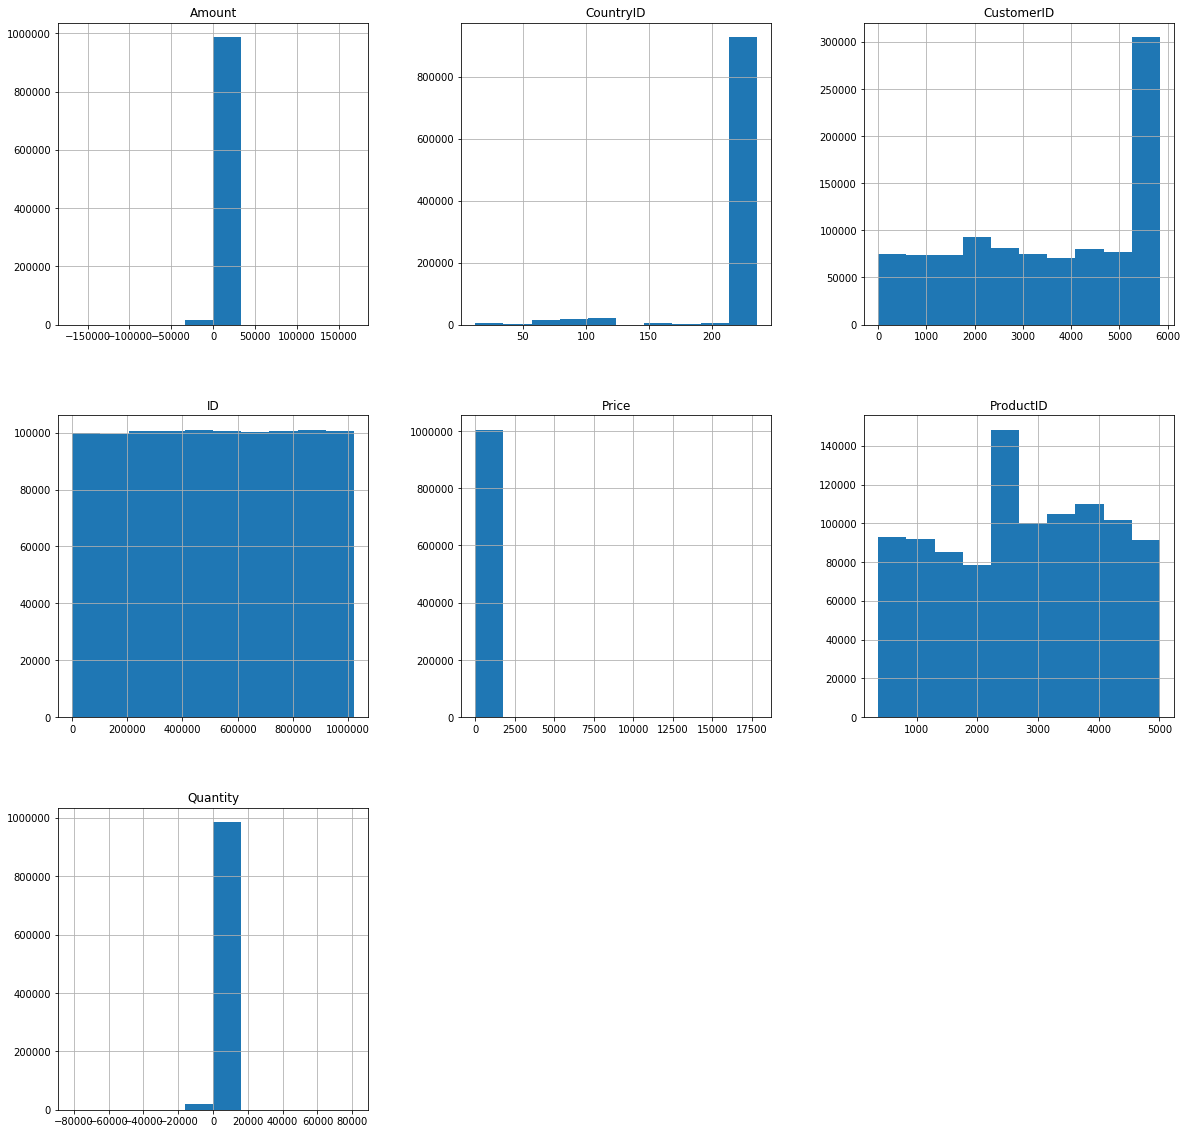

In [22]:
df.hist(figsize=(20,20))
plt.show()

#### Listings price distribution after removing outliers

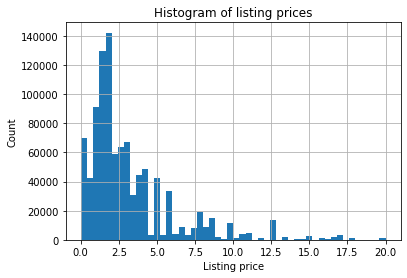

In [23]:
df.loc[(df.Price <= 20) & (df.Price > 0)].Price.hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Listing price')
plt.title('Histogram of listing prices');

In [24]:
print('Max Product Price: ', df.Price.max())

Max Product Price:  17836.46


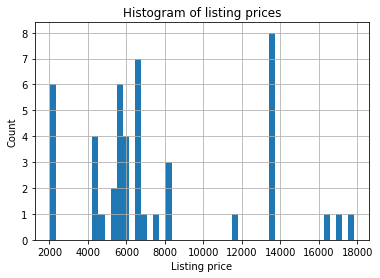

In [25]:
df.loc[(df.Price >= 2000) & (df.Price > 0)].Price.hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Listing price')
plt.title('Histogram of listing prices');

In [26]:
corr_matrix = df.corr()
corr_matrix["CustomerID"].sort_values(ascending=False)

CustomerID    1.000000
CountryID     0.375279
Price         0.017203
ID            0.015202
ProductID    -0.008470
Amount       -0.011029
Quantity     -0.020002
Name: CustomerID, dtype: float64

In [27]:
import seaborn as sns

Var_Corr = df.corr()
Var_Corr

ID  CustomerID  CountryID  ProductID     Price  Quantity  \
ID          1.000000    0.015202  -0.012428   0.010749  0.002100 -0.004049   
CustomerID  0.015202    1.000000   0.375279  -0.008470  0.017203 -0.020002   
CountryID  -0.012428    0.375279   1.000000  -0.015543  0.001814 -0.018620   
ProductID   0.010749   -0.008470  -0.015543   1.000000 -0.013443  0.000625   
Price       0.002100    0.017203   0.001814  -0.013443  1.000000 -0.002053   
Quantity   -0.004049   -0.020002  -0.018620   0.000625 -0.002053  1.000000   
Amount     -0.001241   -0.011029  -0.014176   0.001117 -0.141538  0.836661   

              Amount  
ID         -0.001241  
CustomerID -0.011029  
CountryID  -0.014176  
ProductID   0.001117  
Price      -0.141538  
Quantity    0.836661  
Amount      1.000000

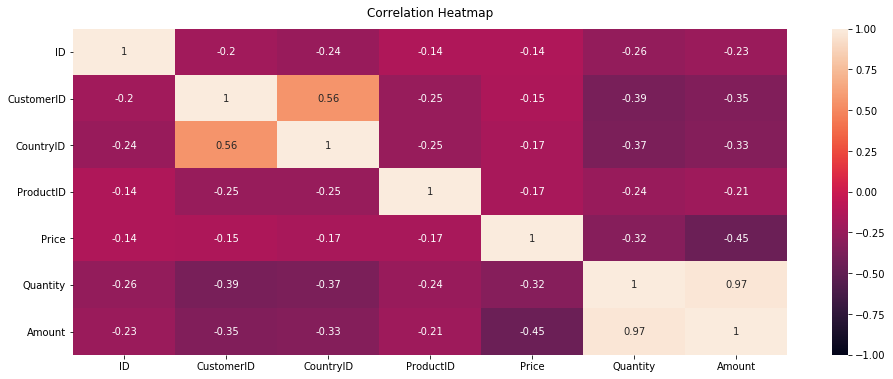

In [28]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(Var_Corr.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

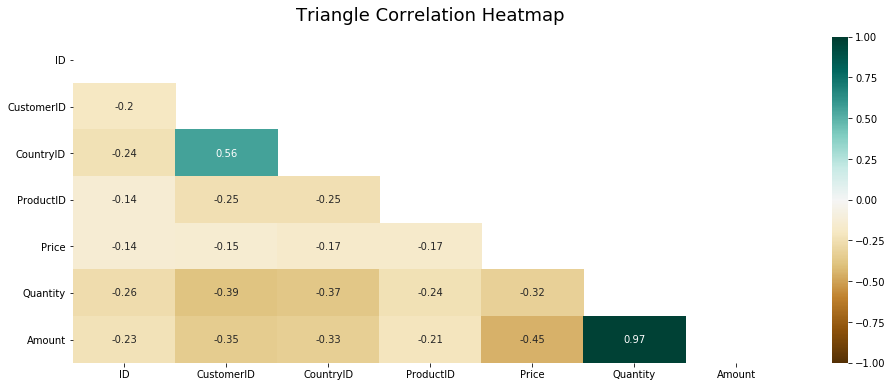

In [29]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(Var_Corr.corr(), dtype=np.bool))
heatmap = sns.heatmap(Var_Corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [30]:
Var_Corr.corr()[['Quantity']].sort_values(by='Quantity', ascending=False)

Quantity
Quantity    1.000000
Amount      0.972873
ProductID  -0.238414
ID         -0.260079
Price      -0.323110
CountryID  -0.373570
CustomerID -0.390262

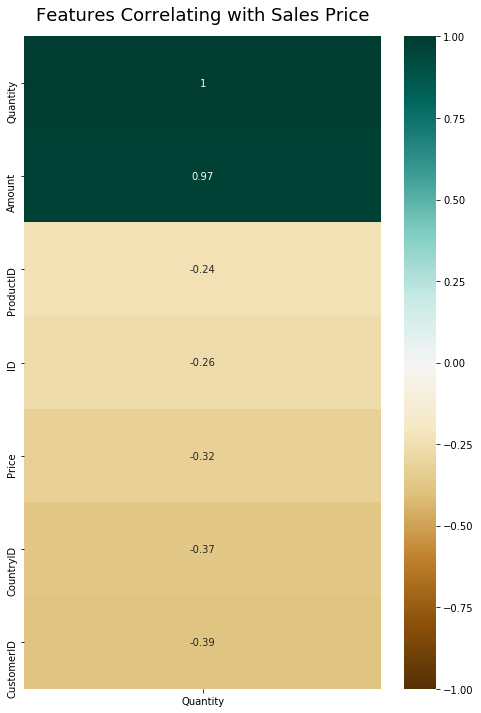

In [31]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(Var_Corr.corr()[['Quantity']].sort_values(by='Quantity', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

In [32]:
# use groupby to aggregate sales by CustomerID
customer_df = df.groupby('CustomerID').agg({'Amount': sum, 
                                            'InvoiceNumber': lambda x: x.nunique()})

# Select the columns we want to use
customer_df.columns = ['TotalSales', 'OrderCount'] 

# create a new column 'AvgOrderValu'
customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']

customer_df.head()

TotalSales  OrderCount  AvgOrderValue
CustomerID                                       
1               169.36           4        42.3400
2              5479.48           8       684.9350
3              2019.40           5       403.8800
4              4418.49           4      1104.6225
5               334.40           1       334.4000

In [33]:
rank_df = customer_df.rank(method='first')
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df.head(5)

TotalSales  OrderCount  AvgOrderValue
CustomerID                                       
1            -1.328931    0.020103      -1.650587
2             1.411745    0.843446       1.529966
3             0.816442    0.297952       1.046282
4             1.321129    0.020704       1.666189
5            -0.863850   -1.731601       0.727626

In [34]:
df.shape

(1004841, 15)

In [35]:
result_df = df.drop_duplicates()
result_df.shape

(1004841, 15)

## Monthly Revenue

In [36]:
#converting the type of Invoice Date Field from string to datetime.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#creating YearMonth field for the ease of reporting and visualization
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)

#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
df['Revenue'] = df['Price'] * df['Quantity']
df_revenue = df.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
df_revenue

InvoiceYearMonth     Revenue
0             201001   718097.65
1             201002   617911.00
2             201003   771232.44
3             201004   705318.46
4             201005   672733.20
5             201006   685301.50
6             201007   847023.60
7             201008   851624.45
8             201009   968697.19
9             201010   963405.27
10            201011  1080964.86
11            201012   598712.50
12            201101   597920.08
13            201102   529332.25
14            201103   702093.39
15            201104   643998.24
16            201105   717010.34
17            201106   730350.75
18            201107   829177.58
19            201108   703316.40
20            201109   980674.39
21            201110   915834.99
22            201111  1257152.48
23            201112   222614.60

In [37]:
#import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [38]:
#X and Y axis inputs for Plotly graph. We use Scatter for line graphs
plot_data = [
    go.Scatter(
        x=df_revenue['InvoiceYearMonth'],
        y=df_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [39]:
#using pct_change() function to see monthly percentage change
df_revenue['MonthlyGrowth'] = df_revenue['Revenue'].pct_change()

#showing first 5 rows
df_revenue.head()

#visualization - line graph
plot_data = [
    go.Scatter(
        x=df_revenue.query("InvoiceYearMonth < 201112")['InvoiceYearMonth'],
        y=df_revenue.query("InvoiceYearMonth < 201112")['MonthlyGrowth'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Growth Rate'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [40]:
df.head()

ID InvoiceNumber         InvoiceDate  CustomerID  CountryID  ProductID  \
0      1       C493411 2010-04-01 09:43:00        2219        235       3596   
1  10669        494435 2010-01-14 12:00:00        2219        235       3596   
2  39425        497250 2010-08-02 12:03:00        2219        235       3596   
3  56575       C499060 2010-02-24 14:03:00        2219        235       3596   
4  74424        500837 2010-10-03 12:04:00        2219        235       3596   

   Price  Quantity  Amount Country_Code         Country Customer_Code  \
0   4.25        -1   -4.25           GB  UNITED KINGDOM        C14590   
1   4.25        18   76.50           GB  UNITED KINGDOM        C14590   
2   4.25        18   76.50           GB  UNITED KINGDOM        C14590   
3   4.25        -2   -8.50           GB  UNITED KINGDOM        C14590   
4   4.25        18   76.50           GB  UNITED KINGDOM        C14590   

                  Customer_Name Product_Code               Product_Name  \
0  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
1  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
2  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
3  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
4  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   

   InvoiceYearMonth  Revenue  
0            201004    -4.25  
1            201001    76.50  
2            201008    76.50  
3            201002    -8.50  
4            201010    76.50

In [41]:
#creating a new dataframe with UK customers only
df_uk = df.query("Country_Code=='GB'").reset_index(drop=True)

#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_active = df_uk.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()

#print the dataframe
df_monthly_active

#plotting the output
plot_data = [
    go.Bar(
        x=df_monthly_active['InvoiceYearMonth'],
        y=df_monthly_active['CustomerID'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Active Customers'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [42]:
#print the dataframe
df_monthly_active

InvoiceYearMonth  CustomerID
0             201001         913
1             201002         835
2             201003         986
3             201004         985
4             201005        1030
5             201006         928
6             201007        1037
7             201008         983
8             201009        1138
9             201010        1253
10            201011        1368
11            201012         820
12            201101         859
13            201102         766
14            201103         909
15            201104         875
16            201105         955
17            201106        1032
18            201107        1029
19            201108         918
20            201109        1122
21            201110        1219
22            201111        1405
23            201112         376

In [43]:
#create a new dataframe for no. of order by using quantity field
df_monthly_sales = df_uk.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()

#print the dataframe
df_monthly_sales

#plot
plot_data = [
    go.Bar(
        x=df_monthly_sales['InvoiceYearMonth'],
        y=df_monthly_sales['Quantity'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Total # of Order'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [44]:
#print the dataframe
df_monthly_sales

InvoiceYearMonth  Quantity
0             201001    297552
1             201002    262578
2             201003    359780
3             201004    345925
4             201005    404844
5             201006    306955
6             201007    392598
7             201008    357029
8             201009    498317
9             201010    428723
10            201011    455301
11            201012    251444
12            201101    255016
13            201102    239020
14            201103    317105
15            201104    326990
16            201105    355067
17            201106    292724
18            201107    382983
19            201108    306006
20            201109    433311
21            201110    390403
22            201111    537657
23            201112     96732

In [45]:
# create a new dataframe for average revenue by taking the mean of it
df_monthly_order_avg = df_uk.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()

#print the dataframe
df_monthly_order_avg

#plot the bar chart
plot_data = [
    go.Bar(
        x=df_monthly_order_avg['InvoiceYearMonth'],
        y=df_monthly_order_avg['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Order Average'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [46]:
#print the dataframe
df_monthly_order_avg

InvoiceYearMonth    Revenue
0             201001  15.616880
1             201002  18.114517
2             201003  17.543515
3             201004  17.120750
4             201005  16.334819
5             201006  15.054278
6             201007  17.379860
7             201008  20.270642
8             201009  18.782929
9             201010  17.179271
10            201011  15.831024
11            201012  17.848417
12            201101  14.016771
13            201102  15.420764
14            201103  18.029833
15            201104  17.190569
16            201105  16.491747
17            201106  15.659824
18            201107  17.692710
19            201108  15.727285
20            201109  19.127214
21            201110  15.416904
22            201111  16.262654
23            201112  15.433341

In [47]:
#create a dataframe contaning CustomerID and first purchase date
tx_min_purchase = df_uk.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_min_purchase.columns = ['CustomerID','MinPurchaseDate']
tx_min_purchase['MinPurchaseYearMonth'] = tx_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)

#merge first purchase date column to our main dataframe (tx_uk)
df_uk = pd.merge(df_uk, tx_min_purchase, on='CustomerID')

df_uk.head()

#create a column called User Type and assign Existing 
#if User's First Purchase Year Month before the selected Invoice Year Month
df_uk['UserType'] = 'New'
df_uk.loc[df_uk['InvoiceYearMonth']>df_uk['MinPurchaseYearMonth'],'UserType'] = 'Existing'

#calculate the Revenue per month for each user type
tx_user_type_revenue = df_uk.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()

#filtering the dates and plot the result
tx_user_type_revenue = tx_user_type_revenue.query("InvoiceYearMonth != 201012 and InvoiceYearMonth != 201112")
plot_data = [
    go.Scatter(
        x=tx_user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'],
        y=tx_user_type_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=tx_user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'],
        y=tx_user_type_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [48]:
tx_user_type_revenue = tx_user_type_revenue.query("InvoiceYearMonth != 201012 and InvoiceYearMonth != 201112")
tx_user_type_revenue

InvoiceYearMonth  UserType     Revenue
0             201001       New   610354.52
1             201002  Existing   265816.03
2             201002       New   263417.70
3             201003  Existing   461994.50
4             201003       New   192501.40
5             201004  Existing   498983.99
6             201004       New   123149.83
7             201005  Existing   492097.43
8             201005       New   105822.27
9             201006  Existing   483465.14
10            201006       New    77095.96
11            201007  Existing   642037.63
12            201007       New    77071.46
13            201008  Existing   698361.38
14            201008       New    61443.10
15            201009  Existing   704892.92
16            201009       New    98941.32
17            201010  Existing   745207.49
18            201010       New    83348.74
19            201011  Existing   853781.04
20            201011       New    80660.99
23            201101  Existing   406823.98
24            201101       New    52267.31
25            201102  Existing   392119.17
26            201102       New    48822.16
27            201103  Existing   542319.52
28            201103       New    53512.38
29            201104  Existing   546153.19
30            201104       New    39529.50
31            201105  Existing   557513.06
32            201105       New    28933.47
33            201106  Existing   557964.19
34            201106       New    31455.94
35            201107  Existing   642205.01
36            201107       New    50853.81
37            201108  Existing   569543.91
38            201108       New    23123.08
39            201109  Existing   780505.00
40            201109       New    53957.96
41            201110  Existing   712901.30
42            201110       New    37208.17
43            201111  Existing  1041403.49
44            201111       New    44340.05

In [49]:
df_uk.head()

ID InvoiceNumber         InvoiceDate  CustomerID  CountryID  ProductID  \
0      1       C493411 2010-04-01 09:43:00        2219        235       3596   
1  10669        494435 2010-01-14 12:00:00        2219        235       3596   
2  39425        497250 2010-08-02 12:03:00        2219        235       3596   
3  56575       C499060 2010-02-24 14:03:00        2219        235       3596   
4  74424        500837 2010-10-03 12:04:00        2219        235       3596   

   Price  Quantity  Amount Country_Code         Country Customer_Code  \
0   4.25        -1   -4.25           GB  UNITED KINGDOM        C14590   
1   4.25        18   76.50           GB  UNITED KINGDOM        C14590   
2   4.25        18   76.50           GB  UNITED KINGDOM        C14590   
3   4.25        -2   -8.50           GB  UNITED KINGDOM        C14590   
4   4.25        18   76.50           GB  UNITED KINGDOM        C14590   

                  Customer_Name Product_Code               Product_Name  \
0  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
1  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
2  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
3  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
4  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   

   InvoiceYearMonth  Revenue     MinPurchaseDate  MinPurchaseYearMonth  \
0            201004    -4.25 2010-01-07 12:33:00                201001   
1            201001    76.50 2010-01-07 12:33:00                201001   
2            201008    76.50 2010-01-07 12:33:00                201001   
3            201002    -8.50 2010-01-07 12:33:00                201001   
4            201010    76.50 2010-01-07 12:33:00                201001   

   UserType  
0  Existing  
1       New  
2  Existing  
3  Existing  
4  Existing

In [50]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
tx_user_ratio = df_uk.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique()/df_uk.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() 
tx_user_ratio = tx_user_ratio.reset_index()
tx_user_ratio = tx_user_ratio.dropna()

#print the dafaframe
tx_user_ratio

#plot the result

plot_data = [
    go.Bar(
        x=tx_user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['InvoiceYearMonth'],
        y=tx_user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['CustomerID'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customer Ratio'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [51]:
#print the dafaframe
tx_user_ratio

InvoiceYearMonth  CustomerID
1             201002    1.783333
2             201003    0.995951
3             201004    0.543887
4             201005    0.428571
5             201006    0.290682
6             201007    0.235995
7             201008    0.206135
8             201009    0.226293
9             201010    0.205967
10            201011    0.201054
11            201012    0.083223
12            201101    0.254015
13            201102    0.259868
14            201103    0.213618
15            201104    0.158940
16            201105    0.120892
17            201106    0.130340
18            201107    0.105263
19            201108    0.087678
20            201109    0.128773
21            201110    0.105168
22            201111    0.088304
23            201112    0.027322

In [52]:
#identify which users are active by looking at their revenue per month
tx_user_purchase = df_uk.groupby(['CustomerID','InvoiceYearMonth'])['Revenue'].sum().reset_index()

#create retention matrix with crosstab
tx_retention = pd.crosstab(tx_user_purchase['CustomerID'], tx_user_purchase['InvoiceYearMonth']).reset_index()

tx_retention.head()

#create an array of dictionary which keeps Retained & Total User count for each month
months = tx_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = tx_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = tx_retention[(tx_retention[selected_month]>0) & (tx_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
tx_retention = pd.DataFrame(retention_array)
tx_retention['RetentionRate'] = tx_retention['RetainedUserCount']/tx_retention['TotalUserCount']

#plot the retention rate graph
plot_data = [
    go.Scatter(
        x=tx_retention.query("InvoiceYearMonth<201112")['InvoiceYearMonth'],
        y=tx_retention.query("InvoiceYearMonth<201112")['RetentionRate'],
        name="organic"
    )
    
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Retention Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [53]:
#identify which users are active by looking at their revenue per month
tx_user_purchase = df_uk.groupby(['CustomerID','InvoiceYearMonth'])['Revenue'].sum().reset_index()
tx_user_purchase.head()

CustomerID  InvoiceYearMonth  Revenue
0           1            201002    27.05
1           1            201006   142.31
2           1            201101     0.00
3           6            201011   290.73
4          18            201108   252.90

# Cohort Analysis with Python

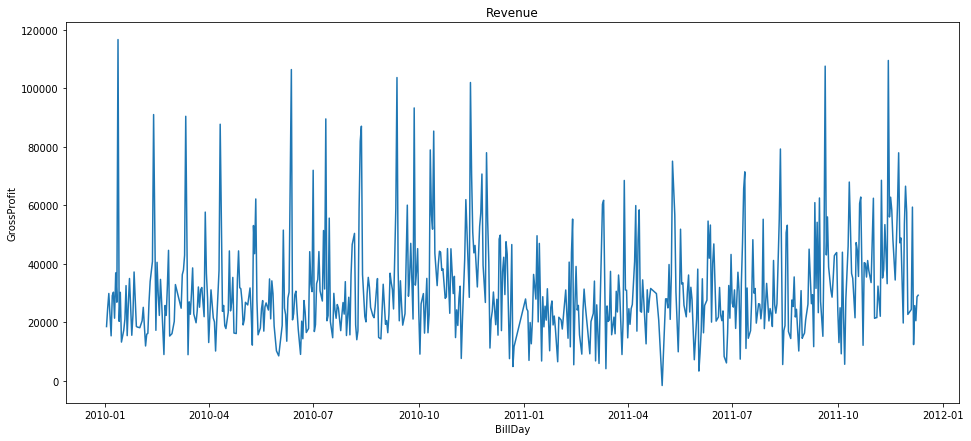

In [54]:
dft19 = df
def daily(x):     
    return dt.datetime(x.year, x.month, x.day, 1)
dft19['BillDay'] = dft19['InvoiceDate'].apply(daily)
df_sum19 = dft19.groupby('BillDay').sum() # .drop('CustomerID', axis = 1)
df_sum19 = df_sum19.rename(columns={'Amount' : 'GrossProfit'})

plt.figure(figsize=(16,7))
sns.lineplot(x = df_sum19.index, y = df_sum19['GrossProfit'])
plt.title("Revenue")
#plt.ylim([0, 1450000])
plt.show()

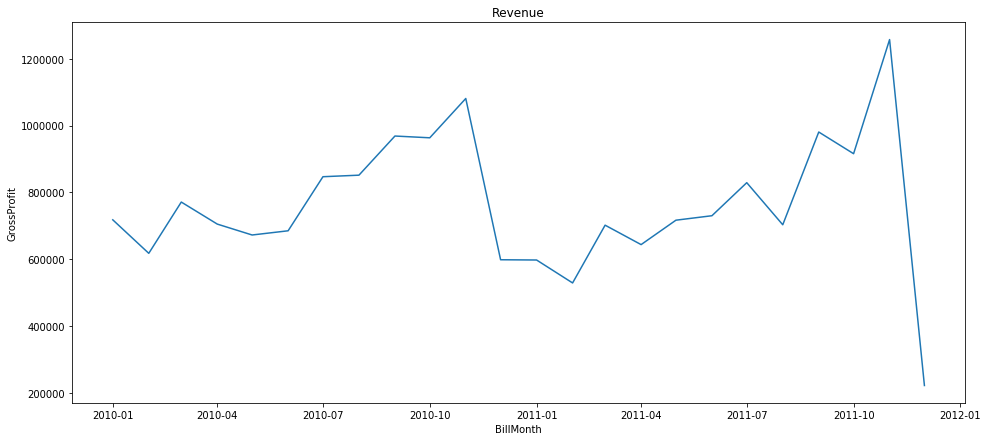

In [55]:
dft19 = df
def monthly(x):     
    return dt.datetime(x.year, x.month, 1)
dft19['BillMonth'] = dft19['InvoiceDate'].apply(monthly)
df_sum = dft19.groupby('BillMonth').sum() # .drop('CustomerID', axis = 1)
df_sum = df_sum.rename(columns={'Amount' : 'GrossProfit'})
plt.figure(figsize=(16,7))
sns.lineplot(x = df_sum.index, y = df_sum['GrossProfit'])
plt.title("Revenue")
#plt.ylim([0, 1450000])
plt.show()

In [56]:
df.columns

Index(['ID', 'InvoiceNumber', 'InvoiceDate', 'CustomerID', 'CountryID',
       'ProductID', 'Price', 'Quantity', 'Amount', 'Country_Code', 'Country',
       'Customer_Code', 'Customer_Name', 'Product_Code', 'Product_Name',
       'InvoiceYearMonth', 'Revenue', 'BillDay', 'BillMonth'],
      dtype='object')

In [57]:
g = dft19.groupby('CustomerID')['BillMonth']
dft19['CohortMonth'] = g.transform('min')
dft19.head(50)

ID InvoiceNumber         InvoiceDate  CustomerID  CountryID  \
0        1       C493411 2010-04-01 09:43:00        2219        235   
1    10669        494435 2010-01-14 12:00:00        2219        235   
2    39425        497250 2010-08-02 12:03:00        2219        235   
3    56575       C499060 2010-02-24 14:03:00        2219        235   
4    74424        500837 2010-10-03 12:04:00        2219        235   
5    89687        502252 2010-03-23 14:29:00        2219        235   
6    89693       C502253 2010-03-23 14:30:00        2219        235   
7   146828        507621 2010-10-05 14:23:00        2219        235   
8   242263        517365 2010-07-28 16:45:00        2219        235   
9   338672       C526270 2010-11-10 11:12:00        2219        235   
10    6017        494019 2010-11-01 09:38:00        5843        235   
11    9516        494381 2010-01-13 17:44:00        5843        235   
12   10246        494387 2010-01-14 09:46:00        5843        235   
13   14612        494782 2010-01-18 13:15:00        5843        235   
14   27291        495951 2010-01-27 17:44:00        5843        235   
15   69966        500351 2010-07-03 15:05:00        5843        235   
16   78494        501161 2010-03-15 09:28:00        5843        235   
17   84074        501686 2010-03-18 16:35:00        5843        235   
18   98069        502985 2010-03-29 14:56:00        5843        235   
19   98200        503016 2010-03-29 15:02:00        5843        235   
20  100045        503185 2010-03-30 14:29:00        5843        235   
21  101987        503426 2010-03-31 17:28:00        5843        235   
22  106336        503823 2010-07-04 14:59:00        5843        235   
23  107250        503871 2010-08-04 11:36:00        5843        235   
24  109274        504104 2010-09-04 14:54:00        5843        235   
25  109295        504106 2010-09-04 14:55:00        5843        235   
26  109356        504110 2010-09-04 14:58:00        5843        235   
27  109402        504115 2010-09-04 15:00:00        5843        235   
28  117929        504916 2010-04-19 10:28:00        5843        235   
29  118785        504924 2010-04-19 10:49:00        5843        235   
30  118967        504928 2010-04-19 10:59:00        5843        235   
31  120167        505016 2010-04-19 13:52:00        5843        235   
32  128697        505864 2010-04-26 13:24:00        5843        235   
33  128705        505866 2010-04-26 13:27:00        5843        235   
34  128738        505868 2010-04-26 13:29:00        5843        235   
35  128877        505879 2010-04-26 13:33:00        5843        235   
36  138657        506871 2010-04-05 15:48:00        5843        235   
37  139880        507009 2010-05-05 14:26:00        5843        235   
38  139897        507010 2010-05-05 14:27:00        5843        235   
39  147068        507649 2010-10-05 15:52:00        5843        235   
40  161089        509347 2010-05-21 13:09:00        5843        235   
41  166483        509935 2010-05-26 12:38:00        5843        235   
42  166500        509936 2010-05-26 12:38:00        5843        235   
43  166546        509939 2010-05-26 12:39:00        5843        235   
44  166592        509941 2010-05-26 12:41:00        5843        235   
45  166973        509962 2010-05-26 12:54:00        5843        235   
46  169892        510228 2010-05-28 09:16:00        5843        235   
47  172511        510519 2010-01-06 13:49:00        5843        235   
48  176723        511006 2010-04-06 14:55:00        5843        235   
49  176753        511007 2010-04-06 14:57:00        5843        235   

    ProductID  Price  Quantity  Amount Country_Code         Country  \
0        3596   4.25        -1   -4.25           GB  UNITED KINGDOM   
1        3596   4.25        18   76.50           GB  UNITED KINGDOM   
2        3596   4.25        18   76.50           GB  UNITED KINGDOM   
3        3596   4.25        -2   -8.50           GB  UNITED KINGDOM   
4        3596   4.25        18 

In [58]:
def get_int(dft19, column):
    year = dft19[column].dt.year
    month = dft19[column].dt.month
    return year, month
billYear, billMonth = get_int(dft19, 'BillMonth')
cohortYear, cohortMonth = get_int(dft19, 'CohortMonth')
diffYear = billYear - cohortYear
diffMonth = billMonth - cohortMonth
dft19['Month_Index'] = diffYear * 12 + diffMonth + 1
dft19.head()

ID InvoiceNumber         InvoiceDate  CustomerID  CountryID  ProductID  \
0      1       C493411 2010-04-01 09:43:00        2219        235       3596   
1  10669        494435 2010-01-14 12:00:00        2219        235       3596   
2  39425        497250 2010-08-02 12:03:00        2219        235       3596   
3  56575       C499060 2010-02-24 14:03:00        2219        235       3596   
4  74424        500837 2010-10-03 12:04:00        2219        235       3596   

   Price  Quantity  Amount Country_Code  ... Customer_Code  \
0   4.25        -1   -4.25           GB  ...        C14590   
1   4.25        18   76.50           GB  ...        C14590   
2   4.25        18   76.50           GB  ...        C14590   
3   4.25        -2   -8.50           GB  ...        C14590   
4   4.25        18   76.50           GB  ...        C14590   

                  Customer_Name Product_Code               Product_Name  \
0  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
1  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
2  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
3  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
4  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   

  InvoiceYearMonth  Revenue             BillDay  BillMonth CohortMonth  \
0           201004    -4.25 2010-04-01 01:00:00 2010-04-01  2010-01-01   
1           201001    76.50 2010-01-14 01:00:00 2010-01-01  2010-01-01   
2           201008    76.50 2010-08-02 01:00:00 2010-08-01  2010-01-01   
3           201002    -8.50 2010-02-24 01:00:00 2010-02-01  2010-01-01   
4           201010    76.50 2010-10-03 01:00:00 2010-10-01  2010-01-01   

  Month_Index  
0           4  
1           1  
2           8  
3           2  
4          10  

[5 rows x 21 columns]

In [59]:
dft19['CohortMonth'] = dft19['CohortMonth'].apply(dt.datetime.date)
g = dft19.groupby(['CohortMonth', 'Month_Index'])
cohortData = g['CustomerID'].apply(pd.Series.nunique).reset_index()
cohortCounts = cohortData.pivot(index = 'CohortMonth', columns = 'Month_Index', values = 'CustomerID')
cohortSizes = cohortCounts.iloc[:, 0]
retention = cohortCounts.divide(cohortSizes, axis = 0) * 100
retention.round(2)

Month_Index     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-01-01   100.0  33.13  38.69  39.49  40.91  36.16  41.82  39.39  41.31   
2010-02-01   100.0  26.75  28.85  30.94  29.02  30.42  28.67  34.62  33.74   
2010-03-01   100.0  24.15  23.58  23.21  23.02  21.51  23.77  26.42  33.40   
2010-04-01   100.0  19.74  20.00  22.63  21.32  26.84  29.21  23.42  13.16   
2010-05-01   100.0  15.66  20.78  18.37  21.39  28.92  25.60  14.76  13.55   
2010-06-01   100.0  14.85  17.03  20.96  18.78  24.89  11.35  10.92   9.61   
2010-07-01   100.0  14.81  14.35  21.30  22.69  11.11  10.65  13.89  12.04   
2010-08-01   100.0  14.44  17.65  21.39  12.83   6.42   6.42  11.23   9.63   
2010-09-01   100.0  18.06  21.15   8.37   7.05   7.05  11.45  11.45  11.01   
2010-10-01   100.0  17.84   9.54   9.54   5.81   9.13  12.03   8.71   8.71   
2010-11-01   100.0  13.11  11.48   6.97   5.74   8.61   6.56  11.89   7.79   
2010-12-01   100.0   6.85   5.48   6.85  12.33   6.85   4.11   6.85   9.59   
2011-01-01   100.0  19.90  20.41  20.92  21.94  23.98  27.55  22.45  26.53   
2011-02-01   100.0  14.67  14.67  16.85  23.37  22.83  23.91  22.83  20.11   
2011-03-01   100.0  20.00  15.43  22.86  21.71  19.43  14.29  25.14  24.57   
2011-04-01   100.0  18.25  16.79  17.52  18.98  22.63  27.74  23.36   3.65   
2011-05-01   100.0  18.97  18.97  19.83  19.83  19.83  26.72   8.62    NaN   
2011-06-01   100.0  18.38  20.59  22.06  20.59  27.21   8.09    NaN    NaN   
2011-07-01   100.0  20.18  22.02  22.94  31.19   2.75    NaN    NaN    NaN   
2011-08-01   100.0  22.62  21.43  28.57   3.57    NaN    NaN    NaN    NaN   
2011-09-01   100.0  17.48  25.17   0.70    NaN    NaN    NaN    NaN    NaN   
2011-10-01   100.0  22.79   0.74    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01   100.0   3.25    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01   100.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

Month_Index     10  ...     15     16     17     18     19     20     21  \
CohortMonth         ...                                                    
2010-01-01   42.22  ...  29.39  28.28  31.72  30.51  31.82  27.78  32.83   
2010-02-01   35.49  ...  20.98  24.65  26.05  26.57  20.28  25.52  26.40   
2010-03-01   19.81  ...  19.06  19.06  18.30  18.11  20.19  24.91  23.02   
2010-04-01   15.00  ...  15.53  13.16  11.58  15.53  15.00  18.95   5.26   
2010-05-01    9.04  ...  16.27  15.96  17.77  21.69  20.18   7.23    NaN   
2010-06-01   10.48  ...  15.28  10.92  15.28  23.58   3.06    NaN    NaN   
2010-07-01   13.89  ...   8.80  11.11  18.06   6.02    NaN    NaN    NaN   
2010-08-01    9.63  ...  10.70  13.90   1.60    NaN    NaN    NaN    NaN   
2010-09-01    7.05  ...  16.74   4.41    NaN    NaN    NaN    NaN    NaN   
2010-10-01    9.96  ...   2.90    NaN    NaN    NaN    NaN    NaN    NaN   
2010-11-01    7.79  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-12-01    6.85  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-01-01   35.71  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-02-01   31.52  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-03-01    4.57  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-04-01     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-05-01     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-06-01     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-07-01     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-08-01     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-09-01     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-10-01     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    Na

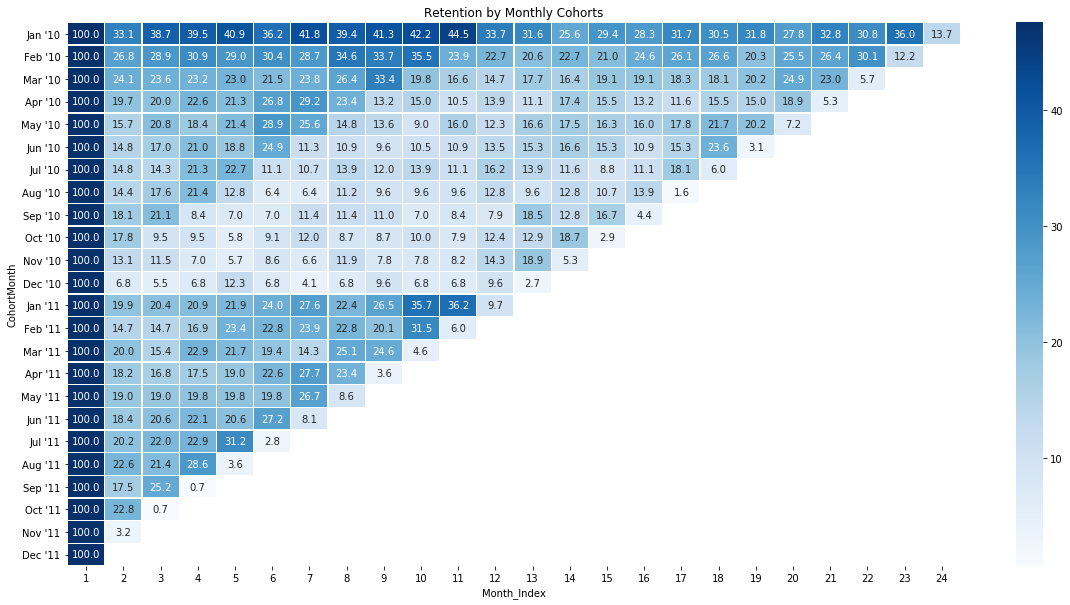

In [60]:
month_list = ["Jan '10", "Feb '10", "Mar '10", "Apr '10", "May '10", "Jun '10", "Jul '10", "Aug '10", "Sep '10", "Oct '10", "Nov '10", "Dec '10"
              , "Jan '11", "Feb '11", "Mar '11", "Apr '11", "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", "Oct '11", "Nov '11", "Dec '11"]
plt.figure(figsize = (20,10))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(retention.round(2), annot = True, cmap = "Blues", vmax = list(retention.max().sort_values(ascending = False))[1]+3, fmt = '.1f', linewidth = 0.3, yticklabels=month_list)
plt.show()

## Select the optimal number of clusters

### Silhouette method

In [61]:
# Use silhouette coefficient to determine the best number of clusters
from sklearn.metrics import silhouette_score

for n_cluster in [4,5,6,7,8]:
    kmeans = KMeans(n_clusters=n_cluster).fit(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])
    
    silhouette_avg = silhouette_score(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']], 
        kmeans.labels_)
    
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 4 Clusters: 0.4137
Silhouette Score for 5 Clusters: 0.3770
Silhouette Score for 6 Clusters: 0.3791
Silhouette Score for 7 Clusters: 0.3661
Silhouette Score for 8 Clusters: 0.3630


### The Elbow Method with the Sum of Squared Errors (SSE)

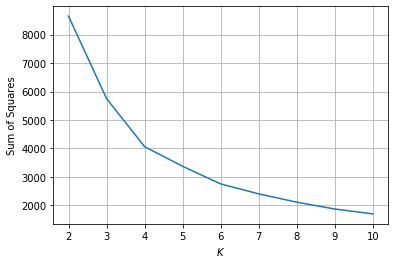

In [62]:
from sklearn import cluster
import numpy as np

sse = []
krange = list(range(2,11))
X = normalized_df[['TotalSales','OrderCount','AvgOrderValue']].values
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=3)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    sse.append(np.sum((X - centers[cluster_assignments]) ** 2))

plt.plot(krange, sse)
plt.grid()
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")
plt.show()

Based on the graph above, it looks like K=4, or 4 clusters is the optimal number of clusters for this analysis. Now let’s interpret the customer segments provided by these clusters.



# Interpreting Customer Segments

In [63]:
kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_

four_cluster_df.head(10)

TotalSales  OrderCount  AvgOrderValue  Cluster
CustomerID                                                
1            -1.328931    0.020103      -1.650587        1
2             1.411745    0.843446       1.529966        2
3             0.816442    0.297952       1.046282        2
4             1.321129    0.020704       1.666189        2
5            -0.863850   -1.731601       0.727626        0
6            -1.000074   -1.731001       0.435976        0
7             0.740229    1.033680      -0.497186        3
8            -0.672417   -0.890255      -0.307553        1
9             0.255944   -1.730401       1.661389        0
10            0.119721   -0.889655       1.252718        0

Now let’s group the cluster metrics and see what we can gather from the normalized data for each cluster.

In [64]:
cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]
cluster4_metrics = kmeans.cluster_centers_[3]

data = [cluster1_metrics, cluster2_metrics, cluster3_metrics, cluster4_metrics]
cluster_center_df = pd.DataFrame(data)

cluster_center_df.columns = four_cluster_df.columns[0:3]
cluster_center_df

TotalSales  OrderCount  AvgOrderValue
0   -0.224094   -0.846322       0.894930
1   -1.234122   -0.877597      -1.024931
2    1.213358    1.035241       0.806187
3    0.219068    0.627108      -0.637613

# Visualizing Clusters

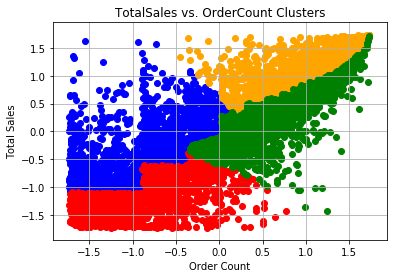

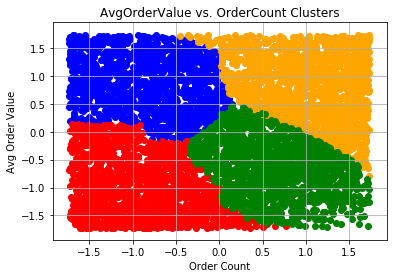

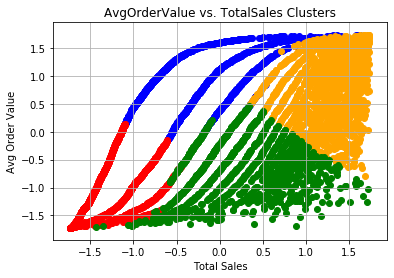

In [65]:
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
c='blue')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
c='red')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
c='orange')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
c='green')
plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')
plt.grid()
plt.show()
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
c='blue')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
c='red')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
c='orange')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
c='green')
plt.title('AvgOrderValue vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')
plt.grid()
plt.show()
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
c='blue')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
c='red')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
c='orange')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
c='green')
plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')
plt.grid()
plt.show()

In the first plot, customers in orange have low total sales AND low order count, meaning they are all-around low-value customers. On the other hand, the customers in red have high total sales AND high order counts, indicating they are the highest value customers.

In the second plot, we’re looking at the average order value vs the order count. Once again, the customers in orange are the lowest value customers and the customers in red are the highest value customers.

In the last plot, we have the average order value versus total sales clusters. This plot further substantiates the previous 2 plots in identifying the red cluster as the highest value customers, orange as the lowest value customers, and the blue and green as high opportunity customers.

# Find the best-selling item by segment
We can better understand the customer segments is to identify which items are the best-selling within each segment. Highest Cluster is the red 'Cluster = 1'

In [66]:
high_value_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 0]
pd.DataFrame(df.loc[df['CustomerID'].isin(high_value_cluster.index)].groupby(
'Product_Name').count()['Product_Code'].sort_values(ascending=False).head(10))

Product_Code
Product_Name                                    
WHITE HANGING HEART T-LIGHT HOLDER           312
REGENCY CAKESTAND 3 TIER                     255
BAKING SET 9 PIECE RETROSPOT                 250
ASSORTED COLOUR BIRD ORNAMENT                231
POSTAGE                                      204
PAPER CHAIN KIT 50'S CHRISTMAS               199
PACK OF 72 RETRO SPOT CAKE CASES             196
RETRO SPOT TEA SET CERAMIC 11 PC             193
VINTAGE SNAP CARDS                           167
REX CASH+CARRY JUMBO SHOPPER                 154

Based on this information, we now know that the WHITE HANGING HEART T-LIGHT HOLDER is the best-selling item for our highest-value cluster. With that information in hand, we can make recommendations of __*Other Items You Might Like*__ to customers within this segment. These actions can be taken to another level of specificity with Association Rule Mining and Market Basket Analysis which I’ll cover below.

In [67]:
# from the above we can put a threshold number to avoid numbers e.g. max 25
print(four_cluster_df['Cluster'].value_counts())

2    1538
1    1517
3    1383
0    1334
Name: Cluster, dtype: int64


In [68]:
print('Customers in Blue Cluster %' , 1383/5772*100)
print('Customers in Red Cluster %' ,1538/5772*100)
print('Customers in Orange Cluster %' ,1334/5772*100)
print('Customers in Green Cluster %' ,1517/5772*100)

Customers in Blue Cluster % 23.96049896049896
Customers in Red Cluster % 26.645876645876648
Customers in Orange Cluster % 23.11157311157311
Customers in Green Cluster % 26.282051282051285


## Customer Lifetime Value

In [69]:
#read data from csv and redo the data work we done before
tx_data = df_all.copy()
#tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_uk = tx_data.query("Country_Code=='GB'").reset_index(drop=True)

#create 3m and 6m dataframes
tx_3m = tx_uk[(tx_uk.InvoiceDate < datetime(2011,6,1)) & (tx_uk.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True)
tx_6m = tx_uk[(tx_uk.InvoiceDate >= datetime(2011,6,1)) & (tx_uk.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)

#create tx_user for assigning clustering
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


#calculate recency score
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#calcuate frequency score
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#calcuate revenue score
tx_3m['Revenue'] = tx_3m['Price'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)


#overall scoring
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>1,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>3,'Segment'] = 'High-Value' 
tx_user.loc[tx_user['OverallScore']>5,'Segment'] = 'Very-High-Value'

In [70]:
#calculate revenue and create a new dataframe for it
tx_6m['Revenue'] = tx_6m['Price'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']


#plot LTV histogram
plot_data = [
    go.Histogram(
        x=tx_user_6m.query('m6_Revenue < 10000')['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [71]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')
tx_merge = tx_merge.fillna(0)

tx_graph = tx_merge.query("m6_Revenue < 30000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'orange',
            opacity= 0.9
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Very-High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Very-High-Value'")['m6_Revenue'],
        mode='markers',
        name='Very_High',
        marker= dict(size= 14,
            line= dict(width=1),
            color= 'red',
            opacity= 0.7
           )
    )
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [72]:
#remove outliers
'''What are Outliers?
An outlier is an observation that is unlike the other observations.
It is rare, or distinct, or does not fit in some way.
We will generally define outliers as samples that are exceptionally far from the mainstream of the data.

Outliers can have many causes, such as:
Measurement or input error.
Data corruption.
True outlier observation (e.g. Michael Jordan in basketball).
'''
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]


#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()


count          mean          std     min      25%       50%  \
LTVCluster                                                                 
0           1522.0    445.574671   481.675183  -823.5     0.00   300.180   
1            305.0   2925.258066  1124.854660  1690.0  2011.13  2557.210   
2             38.0  10053.029211  2870.151861  6840.7  7808.33  9636.285   

                   75%       max  
LTVCluster                        
0             741.3475   1684.69  
1            3538.0800   6328.10  
2           11658.0125  17689.68

## Data engineering for ML

# Transfer data to training and testing set:

In [74]:
#ss = StandardScaler()
#data_df = ss.fit_transform(tx_class)
#X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
#y = tx_class['LTVCluster']

In [75]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster)

#create X and y, X will be feature set and y is the label - LTV
#X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
#y = tx_class['LTVCluster']


data = tx_class.copy()
y = data["LTVCluster"].values
X = data[['CustomerID', 'Recency', 'RecencyCluster', 'Frequency',
       'FrequencyCluster', 'Revenue', 'RevenueCluster', 'OverallScore',
       'Segment_High-Value', 'Segment_Low-Value',
       'Segment_Mid-Value']].values


#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56) # 5% training and 30% test
print(X.shape)
print(y.shape)

(1865, 11)
(1865,)


In [76]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster                 1.000000
m6_Revenue                 0.851494
Revenue                    0.415386
Frequency                  0.335438
Segment_High-Value         0.331916
OverallScore               0.303914
RevenueCluster             0.299194
FrequencyCluster           0.294019
RecencyCluster             0.222268
Segment_Very-High-Value    0.130488
Segment_Mid-Value          0.006777
CustomerID                -0.028833
Segment_Low-Value         -0.187809
Recency                   -0.214809
Name: LTVCluster, dtype: float64

In [77]:
tx_cluster.LTVCluster.unique()

array([1, 0, 2], dtype=int64)

In [78]:
tx_cluster.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0        2235        2               3        577                 2  2613.07   
1        2394        9               3        550                 2  4841.81   
2        3328        7               3        380                 2  1993.83   
3         905        6               3        619                 2  2724.27   
4        2624        5               3        446                 2  2268.62   

   RevenueCluster  OverallScore     Segment  m6_Revenue  LTVCluster  
0               0             5  High-Value     5300.15           1  
1               0             5  High-Value     4708.77           1  
2               0             5  High-Value     2482.88           1  
3               0             5  High-Value     3975.61           1  
4               0             5  High-Value     3128.23           1

In [79]:
tx_class.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0        2235        2               3        577                 2  2613.07   
1        2394        9               3        550                 2  4841.81   
2        3328        7               3        380                 2  1993.83   
3         905        6               3        619                 2  2724.27   
4        2624        5               3        446                 2  2268.62   

   RevenueCluster  OverallScore  m6_Revenue  LTVCluster  Segment_High-Value  \
0               0             5     5300.15           1                   1   
1               0             5     4708.77           1                   1   
2               0             5     2482.88           1                   1   
3               0             5     3975.61           1                   1   
4               0             5     3128.23           1                   1   

   Segment_Low-Value  Segment_Mid-Value  Segment_Very-High-Value  
0                  0                  0                        0  
1                  0                  0                        0  
2                  0                  0                        0  
3                  0                  0                        0  
4                  0                  0                        0

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_df = ss.fit_transform(tx_class)
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']
#Divide into training and test data
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size=0.2, random_state=56) # 5% training and 30% test

# import the necessary packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from mlxtend.evaluate import bias_variance_decomp

tx_class.columns
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']


In [80]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=3, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result.max())
    # estimating the bias and variance
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train,
                                                            y_train, X_test,
                                                            y_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
 
    # summary of the results
    print('Average expected loss: %.3f' % avg_expected_loss)
    print('Average bias: %.3f' % avg_bias)
    print('Average variance: %.3f' % avg_var)
    print('-----------------------------------')

LR 0.8490945674044266
Average expected loss: 0.160
Average bias: 0.140
Average variance: 0.020
-----------------------------------
NB 0.8209255533199196
Average expected loss: 0.194
Average bias: 0.184
Average variance: 0.011
-----------------------------------
RF 0.8309859154929577
Average expected loss: 0.183
Average bias: 0.146
Average variance: 0.038
-----------------------------------
SVC 0.8430583501006036
Average expected loss: 0.170
Average bias: 0.161
Average variance: 0.009
-----------------------------------
Dtree 0.7665995975855131
Average expected loss: 0.297
Average bias: 0.159
Average variance: 0.138
-----------------------------------
XGB 0.8450704225352113
Average expected loss: 0.194
Average bias: 0.153
Average variance: 0.042
-----------------------------------
KNN 0.8148893360160966
Average expected loss: 0.233
Average bias: 0.155
Average variance: 0.078
-----------------------------------


In [81]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=3, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result.max())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    confusion = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix\n')
    print(confusion)
    print('------------------------------------')

LR 0.8490945674044266
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       310
           1       0.48      0.25      0.33        53
           2       0.67      0.20      0.31        10

    accuracy                           0.85       373
   macro avg       0.68      0.47      0.52       373
weighted avg       0.82      0.85      0.83       373

Confusion Matrix

[[303   7   0]
 [ 39  13   1]
 [  1   7   2]]
------------------------------------
NB 0.8209255533199196
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       310
           1       0.40      0.38      0.39        53
           2       0.60      0.30      0.40        10

    accuracy                           0.83       373
   macro avg       0.63      0.53      0.57       373
weighted avg       0.82      0.83      0.82       373

Confusion Matrix

[[285  25   0]
 [ 31  20   2]
 [  2   5   3]]
-----------------------------

In [82]:
# preparing the dataset into inputs (feature matrix) and outputs (target vector)
data = tx_class.copy()
ya = data["LTVCluster"].values
Xa = data[['CustomerID', 'Recency', 'RecencyCluster', 'Frequency',
       'FrequencyCluster', 'Revenue', 'RevenueCluster', 'OverallScore',
       'Segment_High-Value', 'Segment_Low-Value',
       'Segment_Mid-Value']].values

#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['Accuracy','Average expected loss', 'Average bias', 'Average variance'], 
                      columns=['LR','NB', 'RF', 'SVC','Dtree','XGB','KNN'])

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=3, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    #print(name, cv_result.max())
    # estimating the bias and variance
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train,
                                                            y_train, X_test,
                                                            y_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
 
    # summary of the results
    # 4. Evaluate the model
    metrics.loc['Average expected loss',name] = round(avg_expected_loss*100,2)
    metrics.loc['Average bias',name] = round(avg_bias*100,2)
    metrics.loc['Average variance',name] = round(avg_var*100,2)
    metrics.loc['Accuracy',name] = round(cv_result.max()*100,2)
    
metrics

LR     NB     RF    SVC  Dtree    XGB    KNN
Accuracy               84.91  82.09   83.5  84.31   75.7  84.51  81.49
Average expected loss  16.02  19.43  18.39  16.99  29.73  19.43  23.32
Average bias              14  18.36  14.53  16.12  15.89  15.27  15.53
Average variance        2.02   1.07   3.85   0.88  13.84   4.16    7.8

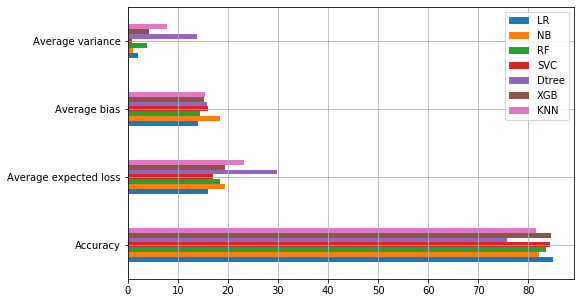

In [83]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
plt.legend(loc=1)
ax.grid();

## Hyperparameter Tuning

In [84]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.8083109919571045)

In [85]:
#XGBoost Multiclassification Model
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight = 1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test, y_test)))

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(xgb_model, X_train,
                                                            y_train, X_test,
                                                            y_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
 
# summary of the results
# 4. Evaluate the model
print('Average expected loss',round(avg_expected_loss*100,2))
print('Average bias' ,round(avg_bias*100,2))
print('Average variance',round(avg_var*100,2))
print('Accuracy', round(cv_result.max()*100,2))
    

Accuracy of XGB classifier on training set: 0.88
Accuracy of XGB classifier on test set: 0.84
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       310
           1       0.43      0.30      0.36        53
           2       0.75      0.30      0.43        10

    accuracy                           0.84       373
   macro avg       0.69      0.52      0.57       373
weighted avg       0.82      0.84      0.83       373

Average expected loss 19.43
Average bias 15.27
Average variance 4.16
Accuracy 81.49


In [86]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test, y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(ltv_xgb_model, X_train,
                                                            y_train, X_test,
                                                            y_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
# summary of the results
# 4. Evaluate the model
print('Average expected loss',round(avg_expected_loss*100,2))
print('Average bias' ,round(avg_bias*100,2))
print('Average variance',round(avg_var*100,2))
print('Accuracy', round(cv_result.max()*100,2))

Accuracy of XGB classifier on training set: 0.94
Accuracy of XGB classifier on test set: 0.83
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       310
           1       0.43      0.36      0.39        53
           2       0.60      0.30      0.40        10

    accuracy                           0.83       373
   macro avg       0.64      0.53      0.57       373
weighted avg       0.82      0.83      0.82       373

Average expected loss 20.75
Average bias 15.46
Average variance 5.29
Accuracy 81.49


In [87]:
#Logistic Regression Multiclassification Model
ltv_LR_model = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train, y_train)

print('Accuracy of LR classifier on training set: {:.2f}'
       .format(ltv_LR_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_LR_model.score(X_test, y_test)))

y_pred = ltv_LR_model.predict(X_test)
print(classification_report(y_test, y_pred))
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(ltv_LR_model, X_train,
                                                            y_train, X_test,
                                                            y_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
# summary of the results
# 4. Evaluate the model
print('Average expected loss',round(avg_expected_loss*100,2))
print('Average bias' ,round(avg_bias*100,2))
print('Average variance',round(avg_var*100,2))
print('Accuracy', round(cv_result.max()*100,2))

Accuracy of LR classifier on training set: 0.83
Accuracy of XGB classifier on test set: 0.85
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       310
           1       0.48      0.25      0.33        53
           2       0.67      0.20      0.31        10

    accuracy                           0.85       373
   macro avg       0.68      0.47      0.52       373
weighted avg       0.82      0.85      0.83       373

Average expected loss 16.02
Average bias 14.0
Average variance 2.02
Accuracy 81.49


In [89]:
train_score = []
test_score = []
k_vals = []

for k in range(1, 21):
    k_vals.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    
    tr_score = knn.score(X_train, y_train)
    train_score.append(tr_score)
    
    te_score = knn.score(X_test, y_test)
    test_score.append(te_score)

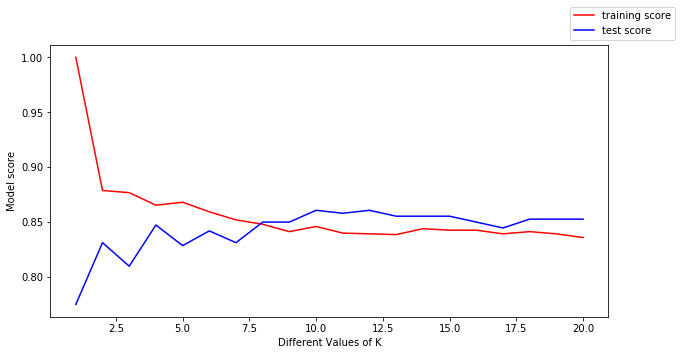

In [90]:
plt.figure(figsize=(10,5))
plt.xlabel('Different Values of K')
plt.ylabel('Model score')
plt.plot(k_vals, train_score, color = 'r', label = "training score")
plt.plot(k_vals, test_score, color = 'b', label = 'test score')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()

## Normalize data

In [91]:
rank_df_n = tx_class[['CustomerID', 'Recency', 'RecencyCluster', 'Frequency',
       'FrequencyCluster', 'Revenue', 'RevenueCluster', 'OverallScore',
       'm6_Revenue', 'Segment_High-Value', 'Segment_Low-Value',
       'Segment_Mid-Value']].rank(method='first')
normalized_df_n = (rank_df_n - rank_df_n.mean()) / rank_df_n.std()
print('Max & Min = ' , normalized_df_n.max().max() , normalized_df_n.min().min())
normalized_df_n.head(5)


Max & Min =  1.7306581727543047 -1.7306581727543047


CustomerID   Recency  RecencyCluster  Frequency  FrequencyCluster  \
0   -0.584933 -1.661952        0.629499   1.728801          1.715803   
1   -0.467946 -1.166152        0.631356   1.726944          1.717660   
2    0.096560 -1.323991        0.633213   1.717660          1.719517   
3   -1.437263 -1.422408        0.635070   1.730658          1.721374   
4   -0.354674 -1.505970        0.636927   1.721374          1.723230   

    Revenue  RevenueCluster  OverallScore  m6_Revenue  Segment_High-Value  \
0  1.619242       -1.730658      1.706518    1.632241            1.485543   
1  1.697233       -1.728801      1.708375    1.602530            1.487400   
2  1.543108       -1.726944      1.710232    1.361129            1.489257   
3  1.628527       -1.725087      1.712089    1.563535            1.491114   
4  1.589532       -1.723230      1.713946    1.463260            1.492971   

   Segment_Low-Value  Segment_Mid-Value  
0          -1.730658          -1.730658  
1          -1.728801          -1.728801  
2          -1.726944          -1.726944  
3          -1.725087          -1.725087  
4          -1.723230          -1.723230

In [92]:
tx_class['LTVCluster'].unique()

array([1, 0, 2], dtype=int64)

In [93]:
#create X and y, X will be feature set and y is the label - LTV

# preparing the dataset into inputs (feature matrix) and outputs (target vector)
yn = tx_class["LTVCluster"].values
# Exclude m6_Revenue
Xn = normalized_df_n[['CustomerID', 'Recency', 'RecencyCluster', 'Frequency',
       'FrequencyCluster', 'Revenue', 'RevenueCluster', 'OverallScore',
       'Segment_High-Value', 'Segment_Low-Value',
       'Segment_Mid-Value']].values


#split training and test sets
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.2, random_state=56)


In [94]:
#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=3, random_state=22)
    cv_result = cross_val_score(model,Xn_train,yn_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result.max())
    model.fit(Xn_train, yn_train)
    yn_pred = model.predict(Xn_test)
    print('Accuracy on training set: {:.2f}'
       .format(model.score(Xn_train, yn_train)))
    print('Accuracy on test set: {:.2f}'
       .format(model.score(Xn_test, yn_test)))
    print(classification_report(yn_test, yn_pred))
    confusion = confusion_matrix(yn_test, yn_pred)
    print('Confusion Matrix\n')
    print(confusion)
    print('------------------------------------')



LR 0.9979879275653923
Accuracy on training set: 0.99
Accuracy on test set: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       310
           1       1.00      1.00      1.00        53
           2       1.00      0.70      0.82        10

    accuracy                           0.99       373
   macro avg       1.00      0.90      0.94       373
weighted avg       0.99      0.99      0.99       373

Confusion Matrix

[[310   0   0]
 [  0  53   0]
 [  3   0   7]]
------------------------------------
NB 0.9336016096579477
Accuracy on training set: 0.91
Accuracy on test set: 0.88
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       310
           1       0.59      0.94      0.72        53
           2       0.59      1.00      0.74        10

    accuracy                           0.88       373
   macro avg       0.72      0.94      0.80       373
weighted avg       0.92      0.8

In [95]:
#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=3, random_state=22)
    cv_result = cross_val_score(model,Xn_train,yn_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result.max())
    model.fit(Xn_train, yn_train)
    yn_pred = model.predict(Xn_test)
    print(classification_report(yn_test, yn_pred))
    confusion = confusion_matrix(yn_test, yn_pred)
    print('Confusion Matrix\n')
    print(confusion)
    print('------------------------------------')

LR 0.9979879275653923
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       310
           1       1.00      1.00      1.00        53
           2       1.00      0.70      0.82        10

    accuracy                           0.99       373
   macro avg       1.00      0.90      0.94       373
weighted avg       0.99      0.99      0.99       373

Confusion Matrix

[[310   0   0]
 [  0  53   0]
 [  3   0   7]]
------------------------------------
NB 0.9336016096579477
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       310
           1       0.59      0.94      0.72        53
           2       0.59      1.00      0.74        10

    accuracy                           0.88       373
   macro avg       0.72      0.94      0.80       373
weighted avg       0.92      0.88      0.89       373

Confusion Matrix

[[268  35   7]
 [  3  50   0]
 [  0   0  10]]
-----------------------------

In [98]:
# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['Accuracy','Average expected loss', 'Average bias', 'Average variance'], 
                      columns=['LR','NB', 'RF', 'SVC','Dtree','XGB','KNN'])

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=3, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    #print(name, cv_result.max())
    # estimating the bias and variance
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, Xn_train,
                                                            yn_train, Xn_test,
                                                            yn_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
 
    # summary of the results
    # 4. Evaluate the model
    metrics.loc['Average expected loss',name] = round(avg_expected_loss*100,2)
    metrics.loc['Average bias',name] = round(avg_bias*100,2)
    metrics.loc['Average variance',name] = round(avg_var*100,2)
    metrics.loc['Accuracy',name] = round(cv_result.max()*100,2)
    
metrics

LR     NB     RF    SVC Dtree    XGB    KNN
Accuracy               84.91  82.09  84.71  84.31  75.7  84.51  81.49
Average expected loss   3.69  16.04   0.14   7.04  0.33    0.2   6.84
Average bias            2.52  13.29   0.02   6.45  0.08   0.12   5.36
Average variance        1.17   2.75   0.12   0.59  0.25   0.08   1.48

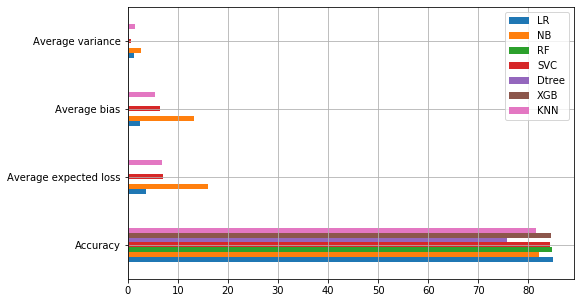

In [99]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
plt.legend(loc=1)
ax.grid();

In [100]:
print(models)

[('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)), ('NB', GaussianNB(priors=None, var_smoothing=1e-09)), ('RF', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)), ('SVC', SVC(C=1.0, break_ties=False, cache_size=200, c

In [101]:
#Pickling the models
import pickle

In [102]:
import _pickle as cPickle

#d = models

with open(r"GAC_Model.pickle", "wb") as output_file:
    cPickle.dump(models, output_file)


# pickle_file will be closed at this point, preventing your from accessing it any further

with open(r"GAC_Model.pickle", "rb") as input_file:
    GAC_Model = cPickle.load(input_file)





In [103]:
print (GAC_Model)

[('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)), ('NB', GaussianNB(priors=None, var_smoothing=1e-09)), ('RF', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)), ('SVC', SVC(C=1.0, break_ties=False, cache_size=200, c

In [104]:
# from the above we can put a threshold number to avoid numbers e.g. max 25
#column = 'ACCT_FULL_NM'
i = 'Country'
if df[i].nunique()<= 40:
    print(i)
    print(df[i].value_counts())

Country
UNITED KINGDOM          923082
IRELAND                  17049
GERMANY                  17004
FRANCE                   13804
NETHERLANDS               4928
SPAIN                     3441
BELGIUM                   2990
SWITZERLAND               2943
PORTUGAL                  2495
AUSTRALIA                 2123
JERSEY                    1587
ITALY                     1490
NORWAY                    1400
SWEDEN                    1336
AUSTRIA                   1192
FINLAND                   1025
CYPRUS                     949
GREECE                     614
DENMARK                    612
JAPAN                      568
UNITED STATES              526
POLAND                     504
UNITED ARAB EMIRATES       434
ISRAEL                     371
HONG KONG                  353
SINGAPORE                  329
MALTA                      292
ICELAND                    250
CANADA                     227
LITHUANIA                  189
SAUDI ARABIA               174
BAHRAIN                    126


## Predicting Next Purchase Day

In [105]:
df_uk.InvoiceDate

0        2010-04-01 09:43:00
1        2010-01-14 12:00:00
2        2010-08-02 12:03:00
3        2010-02-24 14:03:00
4        2010-10-03 12:04:00
                 ...        
923077   2011-08-24 10:52:00
923078   2011-02-11 11:24:00
923079   2010-06-23 12:35:00
923080   2010-10-26 15:00:00
923081   2011-01-04 12:10:00
Name: InvoiceDate, Length: 923082, dtype: datetime64[ns]

In [106]:
df_uk.InvoiceDate < datetime(2011,9,1)

0         True
1         True
2         True
3         True
4         True
          ... 
923077    True
923078    True
923079    True
923080    True
923081    True
Name: InvoiceDate, Length: 923082, dtype: bool

In [107]:
tx_6m = df_uk[(df_uk.InvoiceDate < datetime (2011,9,1)) & (df_uk.InvoiceDate >= datetime (2011,3,1))].reset_index(drop=True)
tx_next = df_uk[(df_uk.InvoiceDate >= datetime (2011,9,1)) & (df_uk.InvoiceDate < datetime (2011,12,1))].reset_index(drop=True)

In [108]:
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

In [109]:
#create a dataframe with customer id and first purchase date in tx_next
tx_next_first_purchase = tx_next.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

#create a dataframe with customer id and last purchase date in tx_6m
tx_last_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

#merge two dataframes
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='CustomerID',how='left')

#calculate the time difference in days:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days

#merge with tx_user 
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

#print tx_user
tx_user.head()

CustomerID  NextPurchaseDay
0        5843              1.0
1        2157             10.0
2        5403              4.0
3        3474             18.0
4        2235              3.0

In [110]:
tx_user.isna().sum()

CustomerID            0
NextPurchaseDay    1132
dtype: int64

In [111]:
tx_user['NextPurchaseDay'] = tx_user['NextPurchaseDay'].fillna(0)


In [112]:
tx_user.isna().sum()

CustomerID         0
NextPurchaseDay    0
dtype: int64

In [113]:
#get max purchase date for Recency and create a dataframe
tx_max_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#find the recency in days and add it to tx_user
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

#plot recency
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#clustering for Recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


#order recency clusters
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#print cluster characteristics
tx_user.groupby('RecencyCluster')['Recency'].describe()


#get total purchases for frequency scores
tx_frequency = tx_6m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

#add frequency column to tx_user
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

#plot frequency
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#clustering for frequency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order frequency clusters and show the characteristics
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user.groupby('FrequencyCluster')['Frequency'].describe()


#calculate monetary value, create a dataframe with it
tx_6m['Revenue'] = tx_6m['Amount']
tx_revenue = tx_6m.groupby('CustomerID').Revenue.sum().reset_index()

#add Revenue column to tx_user
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

#plot Revenue
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Revenue clusters 
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

#ordering clusters and who the characteristics
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)
tx_user.groupby('RevenueCluster')['Revenue'].describe()


#building overall segmentation
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

#assign segment names
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

#plot revenue vs frequency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#plot revenue vs recency
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [114]:
tx_user.head()

CustomerID  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0        5843              1.0        0               3      57092   
1        2157             10.0        7               3        421   
2        2235              3.0        3               3       1349   
3        5239              8.0        0               3        407   
4        1827             14.0        6               3        347   

   FrequencyCluster    Revenue  RevenueCluster  OverallScore     Segment  
0                 3  541696.14               3             9  High-Value  
1                 1    3587.48               0             4   Mid-Value  
2                 1    5400.45               0             4   Mid-Value  
3                 1   10727.47               0             4   Mid-Value  
4                 1    5816.37               0             4   Mid-Value

In [116]:
df.head()

ID InvoiceNumber         InvoiceDate  CustomerID  CountryID  ProductID  \
0      1       C493411 2010-04-01 09:43:00        2219        235       3596   
1  10669        494435 2010-01-14 12:00:00        2219        235       3596   
2  39425        497250 2010-08-02 12:03:00        2219        235       3596   
3  56575       C499060 2010-02-24 14:03:00        2219        235       3596   
4  74424        500837 2010-10-03 12:04:00        2219        235       3596   

   Price  Quantity  Amount Country_Code  ... Customer_Code  \
0   4.25        -1   -4.25           GB  ...        C14590   
1   4.25        18   76.50           GB  ...        C14590   
2   4.25        18   76.50           GB  ...        C14590   
3   4.25        -2   -8.50           GB  ...        C14590   
4   4.25        18   76.50           GB  ...        C14590   

                  Customer_Name Product_Code               Product_Name  \
0  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
1  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
2  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
3  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   
4  EMMERICH, GOTTLIEB AND HALEY       P21539  RED RETROSPOT BUTTER DISH   

  InvoiceYearMonth  Revenue             BillDay  BillMonth CohortMonth  \
0           201004    -4.25 2010-04-01 01:00:00 2010-04-01  2010-01-01   
1           201001    76.50 2010-01-14 01:00:00 2010-01-01  2010-01-01   
2           201008    76.50 2010-08-02 01:00:00 2010-08-01  2010-01-01   
3           201002    -8.50 2010-02-24 01:00:00 2010-02-01  2010-01-01   
4           201010    76.50 2010-10-03 01:00:00 2010-10-01  2010-01-01   

  Month_Index  
0           4  
1           1  
2           8  
3           2  
4          10  

[5 rows x 21 columns]

### Convert whole dataframe from upper case to lower case with Pandas

df = df.applymap(lambda s:s.lower() if type(s) == str else s)
df.head()

df['Amount'].min()

df.shape

In [117]:
# in each column of dataframe
uniqueValues = df.nunique()
 
print('Count of unique value sin each column :')
print(uniqueValues)

Count of unique value sin each column :
ID                  1004841
InvoiceNumber         49393
InvoiceDate           44210
CustomerID             5772
CountryID                40
ProductID              4582
Price                  2114
Quantity                993
Amount                 7451
Country_Code             40
Country                  40
Customer_Code          5772
Customer_Name          5772
Product_Code           4582
Product_Name           4548
InvoiceYearMonth         24
Revenue                7966
BillDay                 583
BillMonth                24
CohortMonth              24
Month_Index              24
dtype: int64


In [118]:
# from the above we can put a threshold number to avoid numbers e.g. max 25
#column = 'ACCT_FULL_NM'
for i in df:
    if df[i].nunique()< 20:
        print(i)
        print(df[i].value_counts())

df.shape

In [ ]:
#To remove all rows where column 'CAMPAIGN' is not needed
#df = df.drop(df[(df.CAMPAIGN == 20190317) | (df.CAMPAIGN == 20180317) | (df.CAMPAIGN == 20180318)].index)

df.dtypes

df.columns
#list(df.columns) 

In [ ]:
#df = df.drop(['BillMonth' ], axis = 1)

In [119]:
print('{:,} rows; {:,} columns'.format(df.shape[0], df.shape[1]))

1,004,841 rows; 21 columns


In [120]:
print('{:,} Customers don\'t have a Customer_Code'.format(df[df.Customer_Code.isnull()].shape[0]))
print('{:,} Products don\'t have a Product_Code'.format(df[df.Product_Code.isnull()].shape[0]))
print('{:,} Countries don\'t have a Country_Code'.format(df[df.Country_Code.isnull()].shape[0]))
print('{:,} Invoices don\'t have a InvoiceNumber'.format(df[df.InvoiceNumber.isnull()].shape[0]))

0 Customers don't have a Customer_Code
0 Products don't have a Product_Code
0 Countries don't have a Country_Code
0 Invoices don't have a InvoiceNumber


In [121]:
# drop those lines as they will not help in our analysis of customers.
#df.dropna(subset=['ACCOUNT'], inplace=True)

In [122]:
df.columns

Index(['ID', 'InvoiceNumber', 'InvoiceDate', 'CustomerID', 'CountryID',
       'ProductID', 'Price', 'Quantity', 'Amount', 'Country_Code', 'Country',
       'Customer_Code', 'Customer_Name', 'Product_Code', 'Product_Name',
       'InvoiceYearMonth', 'Revenue', 'BillDay', 'BillMonth', 'CohortMonth',
       'Month_Index'],
      dtype='object')

format_dict = {col_name: '{:,.2f}' for col_name in g.select_dtypes(float).columns}


In [124]:
format_dict = {col_name: '{:,.2f}' for col_name in g.select_dtypes(float).columns}

g = df.groupby(['Country'])['Amount'].sum().reset_index()
g['count'] = g['Country'].map(df['Country'].value_counts())
g = g.sort_values(by=['Amount'], ascending=False)
g.style.format(format_dict)

AttributeError: Cannot access callable attribute 'select_dtypes' of 'DataFrameGroupBy' objects, try using the 'apply' method

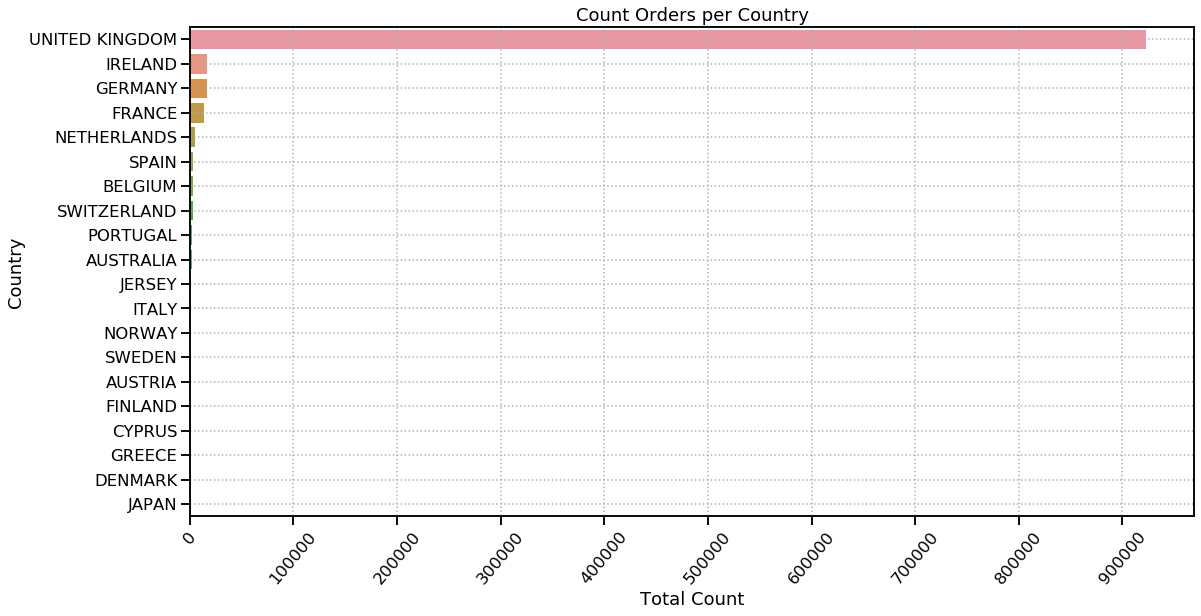

In [125]:
most_selling_products = df['Country'].value_counts()[:20]
#most_selling_products2 = g['count'].value_counts()[:20]
plt.figure(figsize = (18,9))
sns.set_context("talk")
sns.barplot(x = most_selling_products.values, y = most_selling_products.index) #,palette = "tab20c_r")
#plt.xticks(np.arange(0,2501,100),rotation = 90)
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, 1000000, step=100000))
plt.xticks(rotation=50)
plt.title("Count Orders per Country")
plt.xlabel("Total Count")
plt.ylabel("Country")
plt.show()

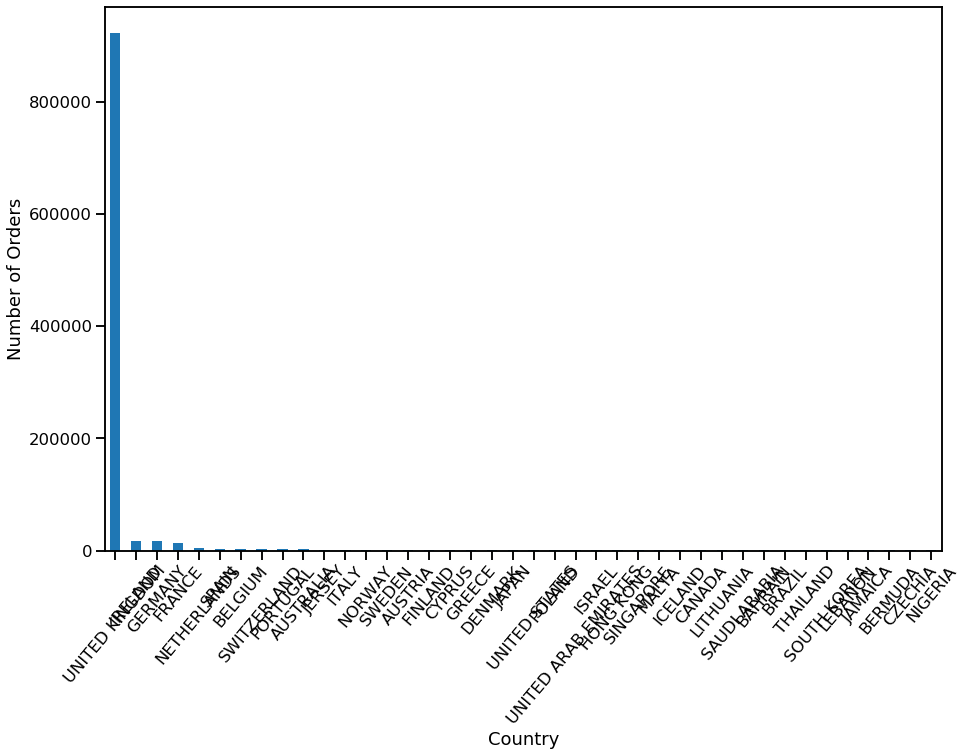

In [126]:
# Groupby by Country
RFM = df.groupby("Country")
plt.figure(figsize=(15,10))
RFM.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Country")
plt.ylabel("Number of Orders")
plt.show()

In [127]:
df.columns

Index(['ID', 'InvoiceNumber', 'InvoiceDate', 'CustomerID', 'CountryID',
       'ProductID', 'Price', 'Quantity', 'Amount', 'Country_Code', 'Country',
       'Customer_Code', 'Customer_Name', 'Product_Code', 'Product_Name',
       'InvoiceYearMonth', 'Revenue', 'BillDay', 'BillMonth', 'CohortMonth',
       'Month_Index'],
      dtype='object')

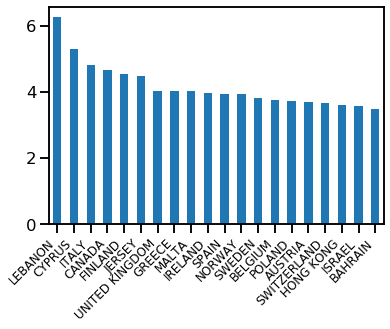

In [128]:
#amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split(","))))
amenities = np.unique(df['Country'])

amenity_prices = [(amn, df[df['Country'].map(lambda amns: amn in amns)]['Price'].mean()) for amn in amenities if amn != ""]
amenity_srs = pd.Series(data=[a[1] for a in amenity_prices], index=[a[0] for a in amenity_prices])

amenity_srs.sort_values(ascending=False)[:20].plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();

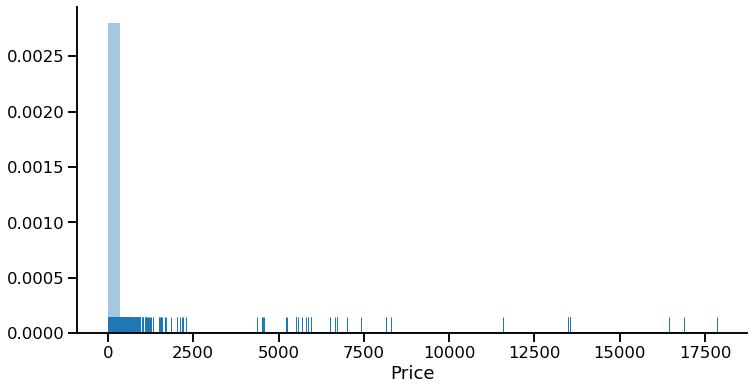

In [129]:
plt.figure(figsize=(12,6))
sns.distplot(df.Price.dropna(), rug=True)
sns.despine()

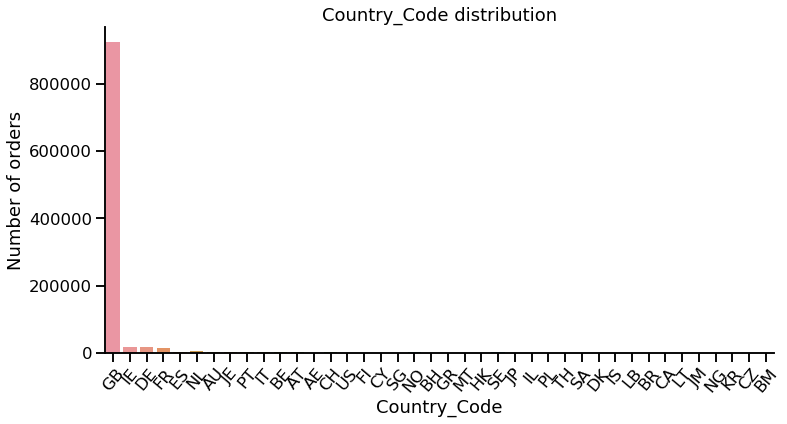

In [130]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Country_Code')
plt.ylabel('Number of orders')
plt.xticks(rotation=50)
plt.title('Country_Code distribution')
sns.despine()

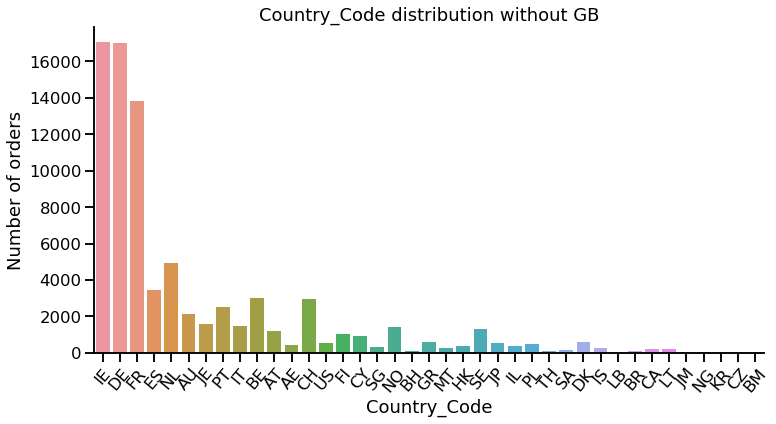

In [131]:
plt.figure(figsize=(12,6))
df_without_GB=df[df['Country_Code']!='GB']
sns.countplot(data=df_without_GB, x='Country_Code')
plt.ylabel('Number of orders')
plt.xticks(rotation=50)
plt.title('Country_Code distribution without GB')
sns.despine()

In [132]:
plt.figure(figsize=(12,6))
df_without_GB=df[df['Country_Code']!='GB']
sns.countplot(x='Country_Code', data = df_without_GB, hue = 'Product_Code')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Users sign up method vs. destinations')
sns.despine()

ValueError: Image size of 754x83569 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x432 with 1 Axes>

In [133]:
# set ALL float columns to '${:,.2f}' formatting (including the percentage)
format_dict = {col_name: '{:,.2f}' for col_name in g.select_dtypes(float).columns}
# override the percentage column
#format_dict['Amount'] = '{:.1%}'

g.head().style.format(format_dict)

AttributeError: Cannot access callable attribute 'select_dtypes' of 'DataFrameGroupBy' objects, try using the 'apply' method

## Invoice date range

In [ ]:
print('Orders from {} to {}'.format(df['InvoiceDate'].min(),
                                    df['InvoiceDate'].max()))

In [ ]:
df['InvoiceNumber'].value_counts().head()

In [ ]:
df.columns

In [ ]:
orders = df.groupby(['InvoiceNumber', 'InvoiceDate', 'CustomerID']).agg({'Amount': lambda x: x.sum()}).reset_index()
orders.head()

Finally, I am going to simulate an analysis I am doing in real time by setting the NOW date at one day after the last purchase. This date will be used as a reference to calculate the Recency score.

In [ ]:
from datetime import timedelta
NOW = orders['InvoiceDate'].max() + timedelta(days=1)
NOW

In [ ]:
period = 365

# Calculate the Recency, Frequency and Monetary Value of each customers

In [ ]:
orders['DaysSinceOrder'] = orders['InvoiceDate'].apply(lambda x: (NOW - x).days)

In [ ]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'InvoiceDate': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = orders.groupby('CustomerID').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'InvoiceDate': 'Frequency'}, inplace=True)
rfm.head()

In [ ]:
rfm['Monetary'] = rfm['CustomerID'].apply(lambda x: orders[(orders['CustomerID'] == x) & \
                                                           (orders['InvoiceDate'] >= NOW - timedelta(days=period))]\
                                                           ['Amount'].sum())
rfm.head()

Calculate the R, F and M scores
At this point, I have the values for Recency, Frequency and Monetary parameters. Each customer will get a note between 1 and 5 for each parameter.
We can do this by setting ranges based on expected behavior. For example, to rate Recency, we could use this scale:
1: 0-30 days
2: 31-60 days
3: 61-90 days
4: 91-180 days
5: 181-365 days

In [ ]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

In [ ]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5   

In [ ]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [ ]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

Segment	Description
Champions	Bought recently, buy often and spend the most
Loyal Customers	Buy on a regular basis. Responsive to promotions.
Potential Loyalist	Recent customers with average frequency.
Recent Customers	Bought most recently, but not often.
Promising	Recent shoppers, but haven’t spent much.
Customers Needing Attention	Above average recency, frequency and monetary values. May not have bought very recently though.
About To Sleep	Below average recency and frequency. Will lose them if not reactivated.
At Risk	Purchased often but a long time ago. Need to bring them back!
Can’t Lose Them	Used to purchase frequently but haven’t returned for a long time.
Hibernating	Last purchase was long back and low number of orders. May be lost.

In [ ]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

## Visualize our customers segments
Now that we have our scores, we can do some data visualization to get a better idea of our customers portfolio. First, let see at the distribution of R, F and M.

In [ ]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

          #################################################################################################

# RFM Analysis for Customer Segmentation
## What is RFM analysis?
RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement

Calculate RFM values
Let’s calculate recency, frequency and monetary values. Also we will assume that we want cluster our customers into 5 segments.

# RFM Analysis for Customer Segmentation
## What is RFM analysis?
RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement

Calculate RFM values
Let’s calculate recency, frequency and monetary values. Also we will assume that we want cluster our customers into 5 segments.

In [ ]:
df.head()

In [ ]:
df.columns

## For 2019

In [ ]:
df19 = df

In [ ]:
calculating_date = max(df19.InvoiceDate) + dt.timedelta(days = 1) # We assume that we are doing this analysis 1 day after from latest transaction on the data.
df19['TotalSum'] = df19['Amount']   #df19['Quantity'] * df19['UnitPrice']
data19 = df19.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (calculating_date - x.max()).days,
    'InvoiceNumber': 'count',
    'TotalSum': 'sum'})

data19.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNumber': 'Frequency',
                         'TotalSum': 'Monetary'}, inplace=True)

data19.head()

In [ ]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5   

In [ ]:
data19['R'] = data19['Recency'].apply(lambda x: r_score(x))
data19['F'] = data19['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
data19['M'] = data19['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [ ]:
data19['RFM Score'] = data19['R'].map(str) + data19['F'].map(str) + data19['M'].map(str)
data19.head()

In [ ]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

data19['Segment'] = data19['R'].map(str) + data19['F'].map(str)
data19['Segment'] = data19['Segment'].replace(segt_map, regex=True)
data19.head()

In [ ]:
data19['RFM_Score'] = data19[['R','F','M']].sum(axis=1)
data19['RFM_Score'].head()

In [ ]:
def rfm_level(df):
    if df['RFM_Score'] >= 14:
        return 'Platinum Plus'
    elif ((df['RFM_Score'] >= 11) and (df['RFM_Score'] < 14)):
        return 'Platinum'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 11)):
        return 'Gold'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 8)):
        return 'Silver'
    else:
        return 'Bronze'

data19['RFM_Level'] = data19.apply(rfm_level, axis=1)

data19.head(10)

In [ ]:
data19.tail(10)

In [ ]:
data19.to_csv('C:/Users/User/OneDrive/GAC/GAC_RFM.csv')

In [ ]:
data19.columns

In [ ]:
# Groupby by RFM_Level
RFM = data19.groupby("RFM_Level")
plt.figure(figsize=(15,10))
RFM.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("RFM_Level")
plt.ylabel("Number of RFM_Level")
plt.show()



In [ ]:
# Groupby by RFM_Level
RFM = data19.groupby("Segment")
plt.figure(figsize=(15,10))
RFM.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Segment")
plt.ylabel("Number of Segment")
plt.show()

In [ ]:
data19.head(2)

In [ ]:
# in each column of dataframe
uniqueValues = data19.nunique()
 
print('Count of unique value sin each column :')
print(uniqueValues)

In [ ]:
# from the above we can put a threshold number to avoid numbers e.g. max 25
#column = 'ACCT_FULL_NM'
for i in data19:
    if data19[i].nunique()< 20:
        print(i)
        print(data19[i].value_counts())

In [ ]:
data19['Segment'].value_counts()

In [ ]:
data19['Segment'].value_counts().sum()

In [ ]:
most_selling_products = data19['Segment'].value_counts()[:20]
plt.figure(figsize = (18,9))
sns.set_context("talk")
sns.barplot(x = most_selling_products.values, y = most_selling_products.index) #,palette = "tab20c_r")
#plt.xticks(np.arange(0,2501,100),rotation = 90)
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, 2500, step=250))
plt.title("Rep Segments in 2019")
plt.xlabel("Total Count")
plt.ylabel("Segment")
plt.show()

In [ ]:
most_selling_products = (data19['Segment'].value_counts())/(data19['Segment'].value_counts().sum())*100
plt.figure(figsize = (18,9))
sns.set_context("talk")
sns.barplot(x = most_selling_products.values, y = most_selling_products.index) #,palette = "tab20c_r")
#plt.xticks(np.arange(0,2501,100),rotation = 90)
plt.xticks(np.arange(0, 35, step=2))
plt.title("Rep Segments % in 2019")
plt.xlabel("Total Count %")
plt.ylabel("Segment")
plt.grid(True, linestyle=':')
plt.show()

In [ ]:
most_selling_products = data19['RFM_Level'].value_counts()[:20]
plt.figure(figsize = (18,9))
sns.set_context("talk")
sns.barplot(x = most_selling_products.values, y = most_selling_products.index) #,palette = "tab20c_r")
#plt.xticks(np.arange(0,2501,100),rotation = 90)
plt.xlabel("Amount")
plt.ylabel("RFM_Level")
plt.title("Rep RFM_Level in 2019")
plt.grid(True, linestyle=':')
plt.show()

In [ ]:
most_selling_products = (data19['RFM_Level'].value_counts())/(data19['RFM_Level'].value_counts().sum())*100
plt.figure(figsize = (18,9))
sns.set_context("talk")
sns.barplot(x = most_selling_products.values, y = most_selling_products.index) #,palette = "tab20c_r")
#plt.xticks(np.arange(0,2501,100),rotation = 90)

plt.title("Rep Segments % in 2019")
plt.xlabel("RFM_Level %")
plt.ylabel("Amount")
plt.show()

In [ ]:
data19.head()

In [ ]:
df.columns

In [ ]:
df.dtypes

In [ ]:
df.head()

In [ ]:
df_model = df.drop(['ID', 'InvoiceNumber', 'InvoiceDate', 'Country_Code', 'Country',
       'Customer_Code', 'Customer_Name', 'Product_Code', 'Product_Name',
       'BillDay', 'BillMonth', 'CohortMonth', 'Month_Index', 'TotalSum'], axis = 1)
df_model.head()

In [ ]:
df_model.corr

In [ ]:
normalized_df.head()

### Random Forest Regressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

y = df_model['Price']
x = df_model.drop('Price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

#### Feature importance of Random Forest

In [ ]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

In [ ]:
### LightGBM

In [ ]:
from lightgbm import LGBMRegressor

y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
fit_params={
    "early_stopping_rounds":20, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto'
           }

In [ ]:
class LGBMRegressor_GainFE(LGBMRegressor):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')

In [ ]:
clf = LGBMRegressor_GainFE(num_leaves= 25, max_depth=20, 
                         random_state=0, 
                         silent=True, 
                         metric='rmse', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.01)
clf.fit(X_train.values, y_train.values, **fit_params)

In [ ]:
y_pred = clf.predict(X_test.values)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

In [ ]:
#### Feature importance of LightGBM

In [ ]:
feat_imp = pd.Series(clf.feature_importances_, index=X.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,6))

############################################################################################################################

In [ ]:
# Data frame for evaluation metrics
metrics = []
metrics = pd.DataFrame(index=['DAC 2019','DAC 2020', 'Not DAC 2019', 'Not DAC 2020', 'All 2019', 'All 2020'], 
                      columns=['NTA', '# DAC_INDICATOR', 'ARS','NTA %', '# DAC_INDICATOR %', 'ARS %'])


#y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['All 2019','NTA'] = df19['NTA_SALES'].sum()
metrics.loc['All 2020','NTA'] = df20['NTA_SALES'].sum()
metrics.loc['All 2019','# DAC_INDICATOR'] = df19['DAC_INDICATOR'].count()
metrics.loc['All 2020','# DAC_INDICATOR'] = df20['DAC_INDICATOR'].count()
metrics.loc['DAC 2019','NTA'] = df19_DAC['NTA_SALES'].sum()
metrics.loc['DAC 2020','NTA'] = df20_DAC['NTA_SALES'].sum()
metrics.loc['Not DAC 2019','NTA'] = df19_NoDAC['NTA_SALES'].sum()
metrics.loc['Not DAC 2020','NTA'] = df20_NoDAC['NTA_SALES'].sum()
metrics.loc['Not DAC 2019','# DAC_INDICATOR'] = df19_NoDAC['DAC_INDICATOR'].count()
metrics.loc['Not DAC 2020','# DAC_INDICATOR'] = df20_NoDAC['DAC_INDICATOR'].count()
metrics.loc['DAC 2019','# DAC_INDICATOR'] = df19_DAC['DAC_INDICATOR'].count()
metrics.loc['DAC 2020','# DAC_INDICATOR'] = df20_DAC['DAC_INDICATOR'].count()

metrics.loc['All 2019','ARS'] = (df19['NTA_SALES'].sum()/df19['ACCOUNT'].nunique())
metrics.loc['All 2020','ARS'] = (df20['NTA_SALES'].sum()/df20['ACCOUNT'].nunique())
metrics.loc['DAC 2019','ARS'] = (df19_DAC['NTA_SALES'].sum()/df19_DAC['ACCOUNT'].nunique())
metrics.loc['DAC 2020','ARS'] = (df20_DAC['NTA_SALES'].sum()/df20_DAC['ACCOUNT'].nunique())
metrics.loc['Not DAC 2019','ARS'] = (df19_NoDAC['NTA_SALES'].sum()/df19_NoDAC['ACCOUNT'].nunique())
metrics.loc['Not DAC 2020','ARS'] = (df20_NoDAC['NTA_SALES'].sum()/df20_NoDAC['ACCOUNT'].nunique())

# percentages:
# NTA %
metrics.loc['All 2020','NTA %'] = ((metrics.loc['All 2020','NTA']-metrics.loc['All 2019','NTA'])/metrics.loc['All 2020','NTA'])*100
metrics.loc['DAC 2020','NTA %'] = ((metrics.loc['DAC 2020','NTA']-metrics.loc['DAC 2019','NTA'])/metrics.loc['DAC 2020','NTA'])*100
metrics.loc['Not DAC 2020','NTA %'] = ((metrics.loc['Not DAC 2020','NTA']-metrics.loc['Not DAC 2019','NTA'])/metrics.loc['Not DAC 2020','NTA'])*100
# Account %
metrics.loc['All 2020','# DAC_INDICATOR %'] = ((metrics.loc['All 2020','# DAC_INDICATOR']-metrics.loc['All 2019','# DAC_INDICATOR'])/metrics.loc['All 2020','# DAC_INDICATOR'])*100
metrics.loc['DAC 2020','# DAC_INDICATOR %'] = ((metrics.loc['DAC 2020','# DAC_INDICATOR']-metrics.loc['DAC 2019','# DAC_INDICATOR'])/metrics.loc['DAC 2020','# DAC_INDICATOR'])*100
metrics.loc['Not DAC 2020','# DAC_INDICATOR %'] = ((metrics.loc['Not DAC 2020','# DAC_INDICATOR']-metrics.loc['Not DAC 2019','# DAC_INDICATOR'])/metrics.loc['Not DAC 2020','# DAC_INDICATOR'])*100
# ARS %
metrics.loc['All 2020','ARS %'] = ((metrics.loc['All 2020','ARS']-metrics.loc['All 2019','ARS'])/metrics.loc['All 2020','ARS'])*100
metrics.loc['DAC 2020','ARS %'] = ((metrics.loc['DAC 2020','ARS']-metrics.loc['DAC 2019','ARS'])/metrics.loc['DAC 2020','ARS'])*100
metrics.loc['Not DAC 2020','ARS %'] = ((metrics.loc['Not DAC 2020','ARS']-metrics.loc['Not DAC 2019','ARS'])/metrics.loc['Not DAC 2020','ARS'])*100


metrics

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.loc[:,'ARS'].plot(kind='barh', ax=ax)
plt.legend(loc=4)
plt.title('ARS in GBP')
ax.grid();

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.loc[:,'# DAC_INDICATOR'].plot(kind='barh', ax=ax)
plt.legend(loc=4)
plt.title('DAC Count')
ax.grid();

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.loc[:,'NTA'].plot(kind='barh', ax=ax)
plt.legend(loc=4)
plt.title('Net to Avon (£10M)')
plt.xlim([0, 10000000])
ax.grid();

In [ ]:
metricsNa = metrics.dropna()
fig, ax = plt.subplots(figsize=(8,5))
metricsNa.loc[:,'ARS %'].plot(kind='barh', ax=ax)
#plt.legend(loc=1)
plt.title('ARS% in 2020 V.S prior year')
ax.grid();

In [ ]:
#metricsNa = metrics.dropna()
fig, ax = plt.subplots(figsize=(8,5))
metricsNa.loc[:,'NTA %'].plot(kind='barh', ax=ax)
#plt.legend(loc=1)
plt.title('NTA% in 2020 V.S prior year')
ax.grid();

In [ ]:
#metricsNa = metrics.dropna()
fig, ax = plt.subplots(figsize=(8,5))
metricsNa.loc[:,'# DAC_INDICATOR %'].plot(kind='barh', ax=ax)
#plt.legend(loc=1)
plt.title('Reps Count% in 2020 V.S prior year')
ax.grid();

In [ ]:
# Create a histogram of ages
df19.hist('NTA_SALES', bins=10);
plt.title('Distribution of NTA_SALES in 2019');
plt.xlabel('NTA_SALES');

In [ ]:
#Sales
df19.NTA_SALES.sum()
plt.hist(df19['NTA_SALES'], log=True, facecolor='blue', alpha=0.5)
plt.xlabel('Amount of NTA Sales in Pounds')
plt.ylabel('Number of Invoices by NTA_SALE')
plt.title('DAC C1: 2019')
# Show the figure
# ticks = 250
# HIst for categories side by side

plt.show()

In [ ]:
#Sales
df19_NoDAC.NTA_SALES.sum()
plt.hist(df19_NoDAC['NTA_SALES'], log=True, facecolor='blue', alpha=0.5)
plt.xlabel('Amount of NTA Sales in Pounds')
plt.ylabel('Number of Invoices by NTA_SALE')
plt.title('Not DAC C1: 2019')
# Show the figure
# ticks = 250
# HIst for categories side by side

plt.show()

In [ ]:
#Sales
df20_DAC.NTA_SALES.sum()
plt.hist(df20_DAC['NTA_SALES'], log=True, facecolor='blue', alpha=0.5)
plt.xlabel('Amount of NTA Sales in Pounds')
plt.ylabel('Number of Invoices by NTA_SALE')
plt.title('DAC C1: 2020')
# Show the figure
# ticks = 250
# HIst for categories side by side

plt.show()

In [ ]:
#Sales
df20_NoDAC.NTA_SALES.sum()
plt.hist(df20_NoDAC['NTA_SALES'], log=True, facecolor='blue', alpha=0.5)
plt.xlabel('Amount of NTA Sales in Pounds')
plt.ylabel('Number of Invoices by NTA_SALE')
plt.title('Not DAC C1: 2020')
# Show the figure
# ticks = 250
# HIst for categories side by side

plt.show()

In [ ]:
out = pd.cut(df19_DAC['NTA_SALES'], bins=[0, 0.5, 1, 2,3,4,5,6,7,8,9,10,15,20,25], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True).mul(100)
ax = out_norm.plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
plt.ylabel("pct")
plt.ylim([0, 20]) 
plt.show()

In [ ]:
out = pd.cut(df19_NoDAC['NTA_SALES'], bins=[0, 0.5, 1, 2,3,4,5,6,7,8,9,10,15,20,25], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True).mul(100)
ax = out_norm.plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
plt.ylabel("pct")
plt.show()

In [ ]:
out = pd.cut(df20_DAC['NTA_SALES'], bins=[0, 0.5, 1, 2,3,4,5,6,7,8,9,10,15,20,25], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True).mul(100)
ax = out_norm.plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
plt.ylabel("pct")
plt.ylim([0, 20]) 
plt.show()

In [ ]:
out = pd.cut(df20_NoDAC['NTA_SALES'], bins=[0, 0.5, 1, 2,3,4,5,6,7,8,9,10,15,20,25], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True).mul(100)
ax = out_norm.plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
plt.ylabel("pct")
plt.ylim([0, 20]) 
plt.show()

In [ ]:
# Create a histogram of ages
df20_NoDAC.hist('NTA_SALES', bins=3);
plt.title('Distribution of Age for DTA in 2018');
plt.xlabel('NTA_SALES');

In [ ]:
df.columns

In [ ]:
df_flag = df.Country_Code.map(dict(GB=1, no=0))
GB = df[df["Country_Code"] == 2]
Not_GB = df[da["Country_Code"] == 1]

In [ ]:
df_flag = df.copy()
df_flag['Flag'] = df.Country_Code
df_flag.Flag[df_flag.Flag != 'GB'] = 0
df_flag.Flag[df_flag.Flag == 'GB'] = 1
df_flag.tail(5)

In [ ]:
n = len(df_flag)
#column = 'ACCT_FULL_NM'
i = 'Flag'
if df_flag[i].nunique()<= 40:
    print(i)
    print(df_flag[i].value_counts())

In [ ]:
n = len(df_flag)
print(n)
df_flag['Flag'].value_counts()

In [ ]:
n = 1004841
GB = 923082
Not_GB = 81759
GB_P = GB/n *100
print(GB_P)
Not_GP_P = Not_GB/n * 100
print(Not_GP_P)

In [ ]:
n = 1004841
GB = 923082
Not_GB = 81759
pnull = Not_GB/n 
phat = GB/n
sm.stats.proportions_ztest(phat * n, n, pnull, alternative='larger')

In [ ]:
from scipy.stats import ttest_1samp
import numpy as np
Country_mean = np.mean(df_flag['Price'])
print(Country_mean)
tset, pval = ttest_1samp(Country_mean, 30)

In [ ]:
print('p-values',pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

In [ ]:
tset, pval = ttest_1samp(df_flag['Flag'], 30)
print(“p-values”,pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

In [ ]:
df_Slaes = df.copy()
df_Slaes['P_Flag'] = df.Price
df_Slaes.P_Flag[df_Slaes.P_Flag <= 5] = 0
df_Slaes.P_Flag[df_Slaes.P_Flag > 5 ] = 1
df_Slaes.tail(5)

In [ ]:
n = len(df_Slaes)
print(n)
df_Slaes['P_Flag'].value_counts()

In [ ]:
n = 1004841
Less5 = 835108
Higher5 = 169733
Less5_P = Less5/n *100
print(Less5_P)
Higher5_P = Higher5/n * 100
print(Higher5_P)

**-------------------------------------------------------------------------------------------------------------------------**
# PG:

In [ ]:
df.head()

In [ ]:
#You could use loc to get series and then iloc to get first element:
df.loc[df['CustomerID'] == 219, 'Customer_Code'].iloc[0]

In [ ]:
#You could use loc to get series and then iloc to get first element:
df.loc[df['CustomerID'] == 219, 'Country'].iloc[0]

In [ ]:
# You could use loc to get series:
df.loc[df['CustomerID'] == 219, 'Product_Code']

In [ ]:
df[df['CustomerID'] == 219]